#  spectra holo at AuxTel for Scan data

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : October 14th  2021



- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

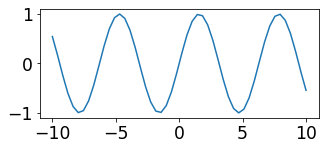

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [7]:
string_date

'2022-01-13'

In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.7.0'

In [10]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [11]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [12]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

# Function

In [15]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^holo4_003_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target(filename):
    m = re.findall('^holo4_003_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

In [16]:
def file_tag_forsorting_ronchi(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^ronchi170lpmm_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target_ronchi(filename):
    m = re.findall('^ronchi170lpmm_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

# Config

In [17]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [18]:
version="v4.0"

# Path

In [19]:
HOSTCC=False

In [20]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/softs/github/lsst/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

In [21]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [22]:
! ls -l /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_RG610_HD160617_20210707_000234_quickLookExp/basespec

total 19384
-rw-r--r--  1 dagoret  staff      607 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_lines.csv
-rw-r--r--  1 dagoret  staff  4970880 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_spectrogram.fits
-rw-r--r--  1 dagoret  staff  4754880 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_spectrum.fits
-rw-r--r--  1 dagoret  staff   191794 Oct 14 21:51 holo4_003_RG610_HD160617_20210707_000234_quickLookExp_table.csv


In [23]:

# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

# Logbook for file selection

In [24]:
# Logbook for scan data
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_'+ version+'.csv'

In [25]:
df=pd.read_csv(filename_logbook,index_col=0)

In [26]:
pd.set_option('display.max_rows', None)

In [27]:
df

index                     date  \
0        0  2021-07-08T02:50:31.569   
1        1  2021-07-08T02:51:12.101   
2        2  2021-07-08T02:51:21.256   
3        3  2021-07-08T02:51:30.934   
4        4  2021-07-08T02:51:40.885   
5        5  2021-07-08T02:51:50.381   
6        6  2021-07-08T02:51:59.759   
7        7  2021-07-08T02:52:10.113   
8        8  2021-07-08T02:52:19.262   
9        9  2021-07-08T02:52:29.022   
10      10  2021-07-08T03:09:18.381   
11      11  2021-07-08T03:09:51.483   
12      12  2021-07-08T03:10:22.899   
13      13  2021-07-08T03:10:54.635   
14      14  2021-07-08T03:14:25.113   
15      15  2021-07-08T03:18:49.728   
16      16  2021-07-08T03:22:35.058   
17      17  2021-07-08T03:27:28.637   
18      18  2021-07-08T03:31:49.398   
19      19  2021-07-08T03:33:02.383   
20      20  2021-07-08T03:33:40.416   
21      21  2021-07-08T03:34:18.506   
22      22  2021-07-08T03:34:56.504   
23      23  2021-07-08T03:35:34.622   
24      24  2021-07-08T03:36:12.773   
25      25  2021-07-08T03:36:51.324   
26      26  2021-07-08T03:37:29.434   
27      27  2021-07-08T03:38:07.561   
28      28  2021-07-08T03:38:45.707   
29      29  2021-07-08T03:39:23.969   
30      30  2021-07-08T03:40:02.136   
31      31  2021-07-08T03:40:40.864   
32      32  2021-07-08T03:41:19.059   
33      33  2021-07-08T03:41:57.407   
34      34  2021-07-08T03:42:35.608   
35      35  2021-07-08T03:43:13.804   
36      36  2021-07-08T03:43:52.018   
37      37  2021-07-08T03:44:30.763   
38      38  2021-07-08T03:45:08.962   
39      39  2021-07-08T03:45:47.206   
40      40  2021-07-08T03:46:25.307   
41      41  2021-07-08T03:47:03.492   
42      42  2021-07-08T03:47:41.807   
43      43  2021-07-08T03:48:20.795   
44      44  2021-07-08T03:48:58.912   
45      45  2021-07-08T03:49:37.128   
46      46  2021-07-08T03:50:15.298   
47      47  2021-07-08T03:50:53.476   
48      48  2021-07-08T03:51:31.752   
49      49  2021-07-08T03:52:10.906   
50      50  2021-07-08T03:52:49.130   
51      51  2021-07-08T03:53:27.487   
52      52  2021-07-08T03:54:05.770   
53      53  2021-07-08T03:54:44.149   
54      54  2021-07-08T03:55:22.356   
55      55  2021-07-08T03:57:27.244   
56      56  2021-07-08T04:01:50.450   
57      57  2021-07-08T04:04:12.555   
58      58  2021-07-08T04:05:06.367   
59      59  2021-07-08T04:05:38.880   
60      60  2021-07-08T04:06:11.311   
61      61  2021-07-08T04:06:43.769   
62      62  2021-07-08T04:07:16.223   
63      63  2021-07-08T04:07:48.665   
64      64  2021-07-08T04:08:21.107   
65      65  2021-07-08T04:08:54.078   
66      66  2021-07-08T04:09:26.572   
67      67  2021-07-08T04:09:59.052   
68      68  2021-07-08T04:10:31.515   
69      69  2021-07-08T04:11:03.986   
70      70  2021-07-08T04:11:36.404   
71      71  2021-07-08T04:12:08.868   
72      72  2021-07-08T04:22:19.093   
73      73  2021-07-08T04:22:52.079   
74      74  2021-07-08T04:23:23.868   
75      75  2021-07-08T04:27:28.703   
76      76  2021-07-08T04:49:32.013   
77      77  2021-07-08T04:50:04.270   
78      78  2021-07-08T04:50:36.514   
79      79  2021-07-08T04:51:08.758   
80      80  2021-07-08T04:51:41.005   
81      81  2021-07-08T04:52:13.265   
82      82  2021-07-08T04:52:45.515   
83      83  2021-07-08T04:53:18.264   
84      84  2021-07-08T04:53:50.521   
85      85  2021-07-08T04:54:22.770   
86      86  2021-07-08T04:54:55.016   
87      87  2021-07-08T04:55:27.314   
88      88  2021-07-08T04:55:59.559   
89      89  2021-07-08T04:56:31.807   
90      90  2021-07-08T04:57:04.543   
91      91  2021-07-08T04:57:36.808   
92      92  2021-07-08T04:58:09.080   
93      93  2021-07-08T04:58:41.316   
94      94  2021-07-08T04:59:13.646   
95      95  2021-07-08T04:59:45.917   
96      96  2021-07-08T05:00:18.159   
97      97  2021-07-08T05:00:50.866   
98      98  2021-07-08T05:01:23.102   
99      99  2021-07-08T05:01:55.386   
100    100  2021-07-08T05:02:27.623   
101    101  2021-07-08T05:0

# Selection of input file

In [28]:
# Do not consider flag
df_good=df[df["quality"]==1]

In [29]:
# Select narrow scan
#df_good=df[df["num"]>=317]

In [30]:
df_good=df[df["num"]>=247]

In [31]:
# With filter
df_good=df[df["num"] != 306]
df_good=df[df["num"] != 307]
df_good=df[df["num"] != 308]

In [32]:
#df_good

In [33]:
for spectra_file in df_good["file"]:
    print(spectra_file)

holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000250_quickLookExp.fi

# Selection of Spectractor output files

In [34]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [35]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


for subdir in list_of_files:
    
    
    tag=file_tag_forsorting(subdir)
    
        
        
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
    if tag <= "000247" : # remove files with filters
        continue
        
    #if tag == "000250" or tag == "000251"  or tag == "000252": # remove file bad angle
    #    continue
        
    if tag == "000306" or tag == "000307" or tag == "000308" : # remove files with filters
        continue
        
    if tag =="000264" :   # creazy reconstruction, truncation on right
        continue
        
    if tag=="000327" or tag=="000333" or tag == "000350" or tag == "000351":
        continue
        
        
        
        
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=file_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        targetname=file_target(subdir)
        print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)






LISTNUM=sorted(LISTNUM)
LISTNUMNODIR=sorted(LISTNUMNODIR)
LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


---------------------------------------------
holo4_003_empty_HD160617_20210707_000248_quickLookExp  	   000248
holo4_003_empty_HD160617_20210707_000248_quickLookExp is a directory
tagname= 000248
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000249_quickLookExp  	   000249
holo4_003_empty_HD160617_20210707_000249_quickLookExp is a directory
tagname= 000249
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000250_quickLookExp  	   000250
holo4_003_empty_HD160617_20210707_000250_quickLookExp is a directory
tagname= 000250
targetname= HD160617
dir_plots is not empty
dir_spectration is not empty
---------------------------------------------
holo4_003_empty_HD160617_20210707_000251_quickLookExp  	   000251
holo4_003_empty_HD160617_20210707_000251_quickLookExp is a directory
tagname= 

In [36]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000265_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000266_quickLookExp/basespec', '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectra

In [37]:
! ls /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp/basespec

holo4_003_empty_HD160617_20210707_000336_quickLookExp_lines.csv
holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrogram.fits
holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits
holo4_003_empty_HD160617_20210707_000336_quickLookExp_table.csv


In [38]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [39]:
all_files_spectra[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits']

In [40]:
all_files_spectrogram[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrogram.fits']

In [41]:
all_files_lines[:3]

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_lines.csv']

In [42]:
all_files_table[:3] 

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_table.csv']

# Selection of good spectra

In [43]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [44]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [45]:
filename.split(".")[0]

'holo4_003_empty_HD160617_20210707_000349_quickLookExp_table'

0 ) holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000248_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000248_quickLookExp_spectrum.fits


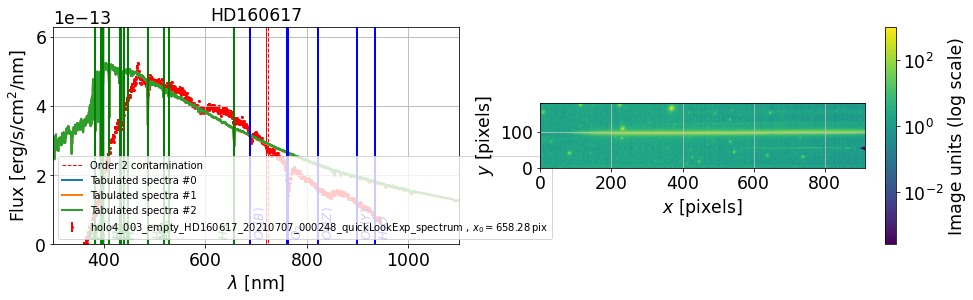

1 ) holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000249_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000249_quickLookExp_spectrum.fits


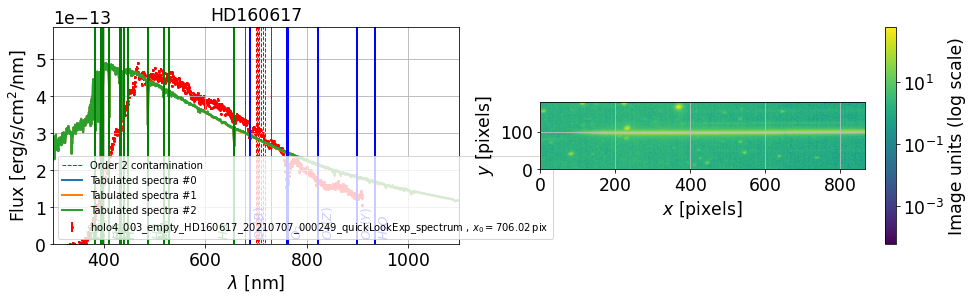

2 ) holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000250_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000250_quickLookExp_spectrum.fits


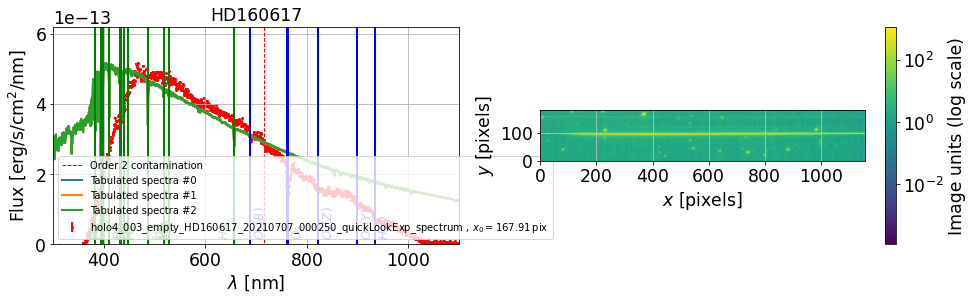

3 ) holo4_003_empty_HD160617_20210707_000251_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000251_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000251_quickLookExp_spectrum.fits


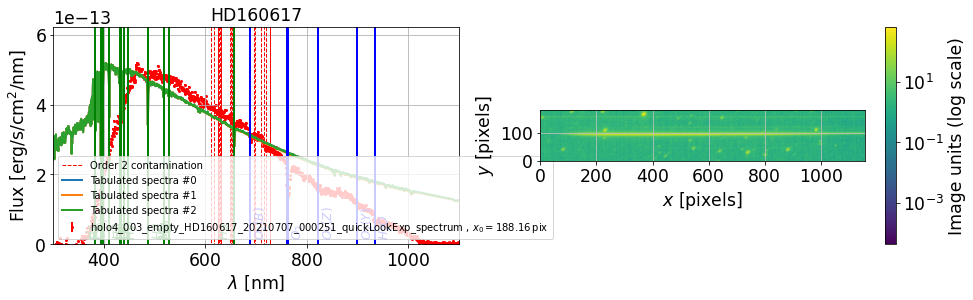

4 ) holo4_003_empty_HD160617_20210707_000252_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000252_quickLookExp_spectrum.fits


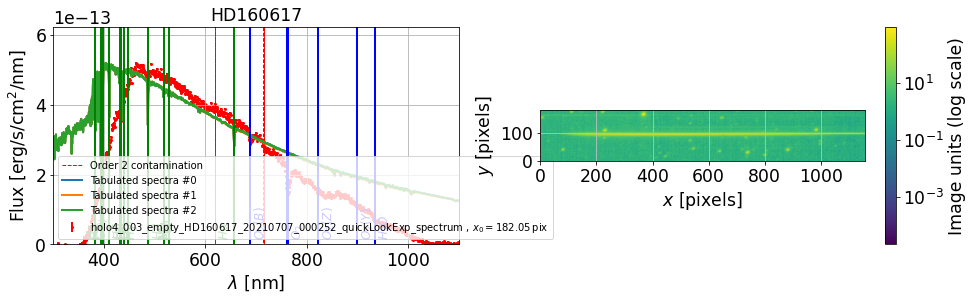

5 ) holo4_003_empty_HD160617_20210707_000265_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000265_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000265_quickLookExp_spectrum.fits


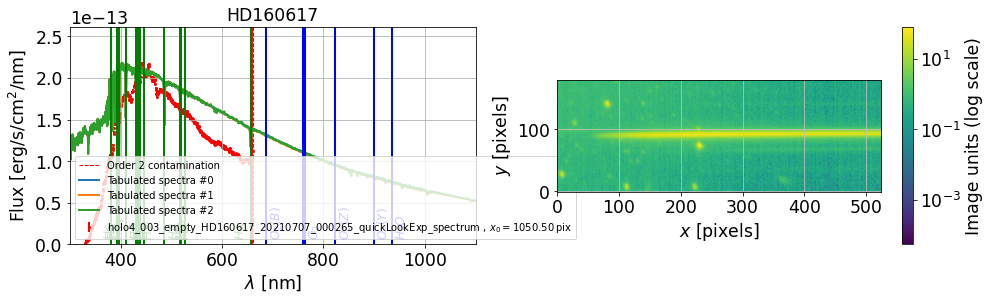

6 ) holo4_003_empty_HD160617_20210707_000266_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000266_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000266_quickLookExp_spectrum.fits


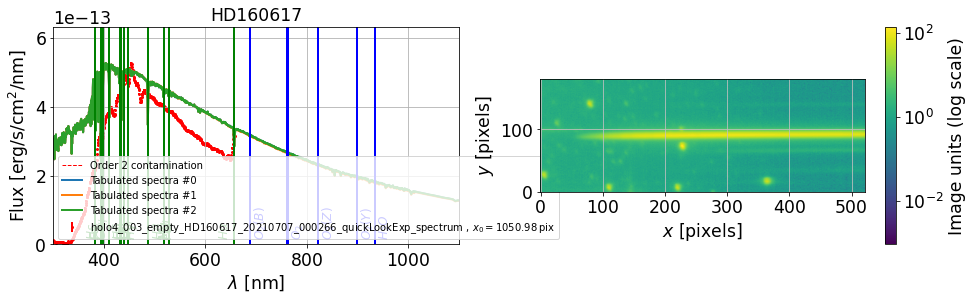

7 ) holo4_003_empty_HD160617_20210707_000267_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000267_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000267_quickLookExp_spectrum.fits


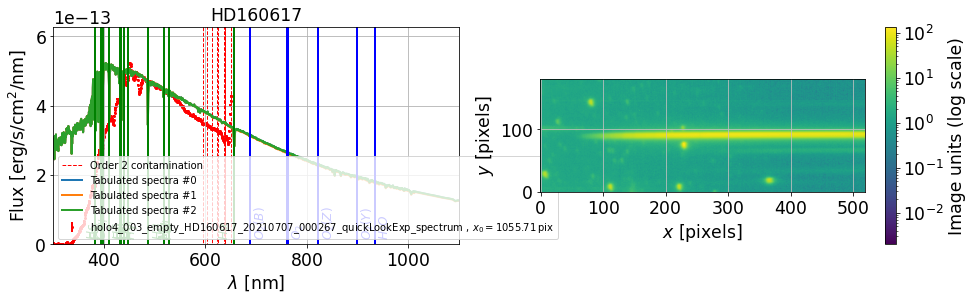

8 ) holo4_003_empty_HD160617_20210707_000268_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000268_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000268_quickLookExp_spectrum.fits


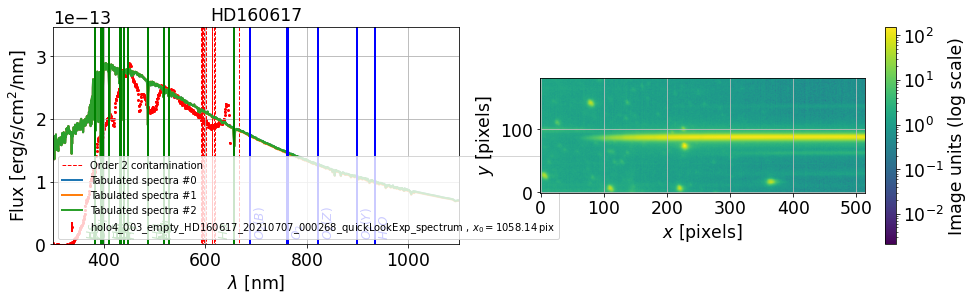

9 ) holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000269_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000269_quickLookExp_spectrum.fits


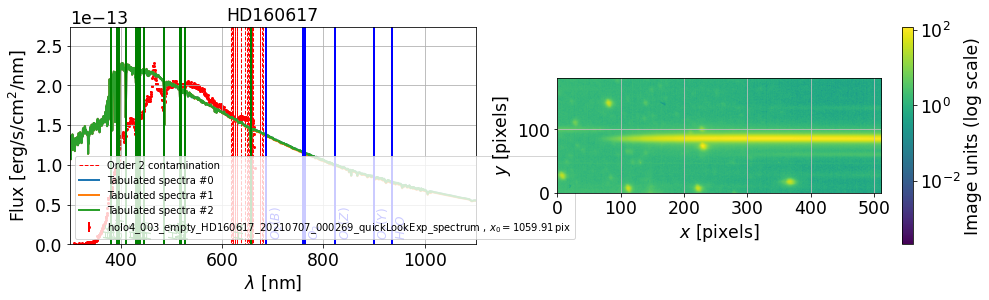

10 ) holo4_003_empty_HD160617_20210707_000270_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000270_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000270_quickLookExp_spectrum.fits


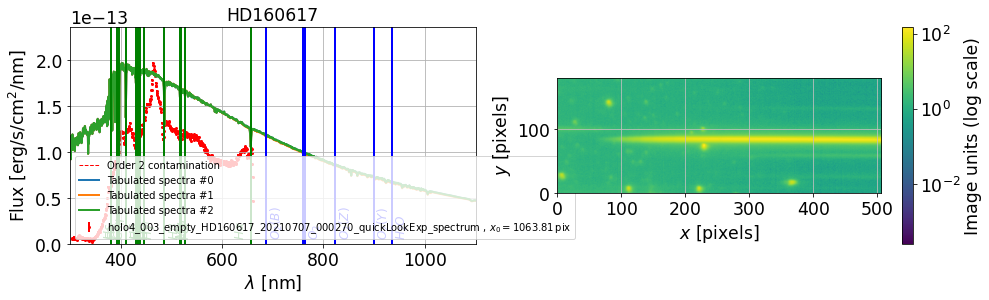

11 ) holo4_003_empty_HD160617_20210707_000272_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000272_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000272_quickLookExp_spectrum.fits


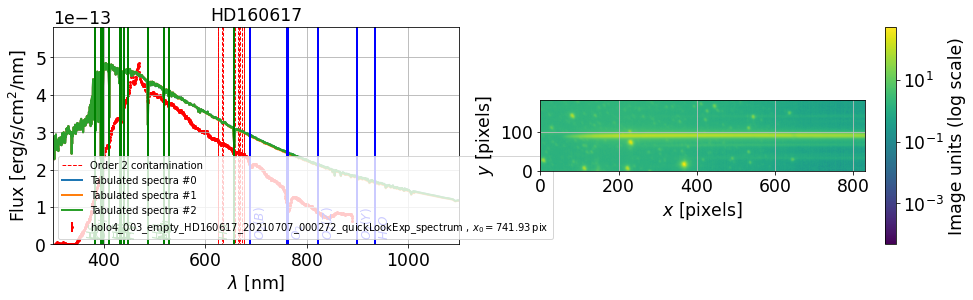

12 ) holo4_003_empty_HD160617_20210707_000273_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000273_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000273_quickLookExp_spectrum.fits


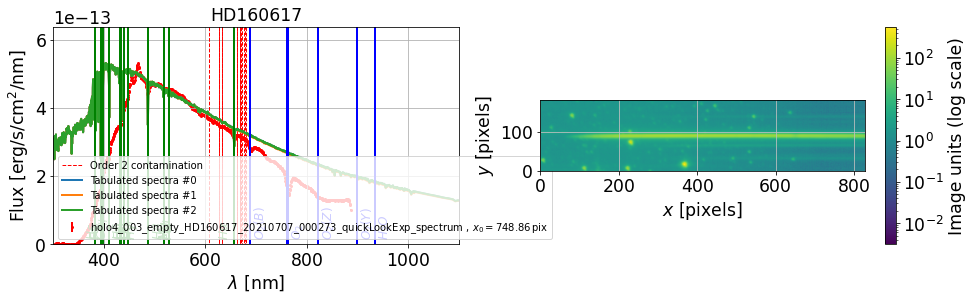

13 ) holo4_003_empty_HD160617_20210707_000274_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000274_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000274_quickLookExp_spectrum.fits


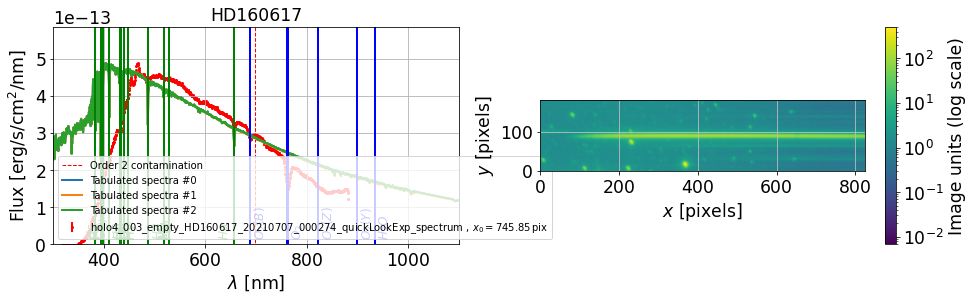

14 ) holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000276_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits


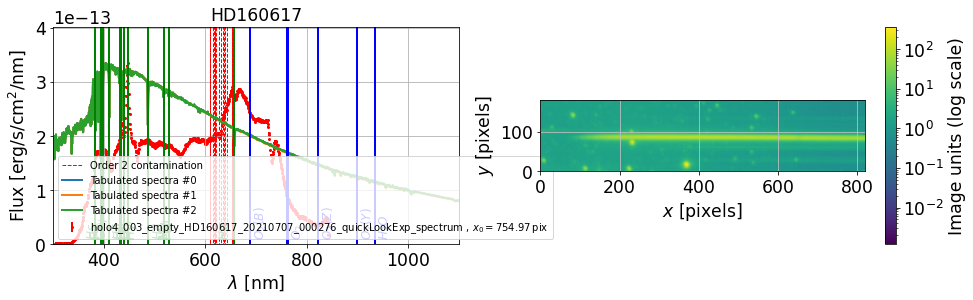

15 ) holo4_003_empty_HD160617_20210707_000278_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000278_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000278_quickLookExp_spectrum.fits


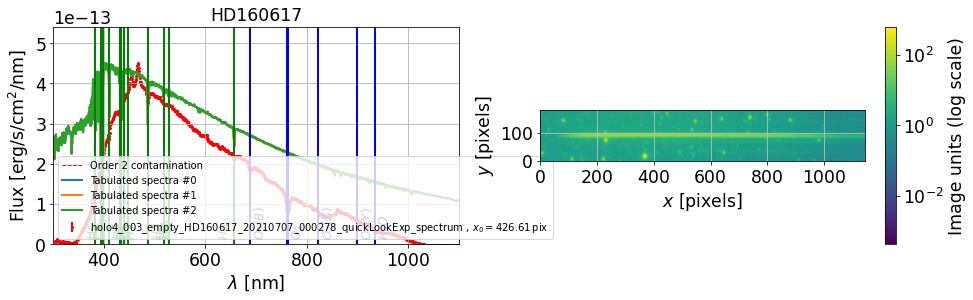

16 ) holo4_003_empty_HD160617_20210707_000279_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000279_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000279_quickLookExp_spectrum.fits


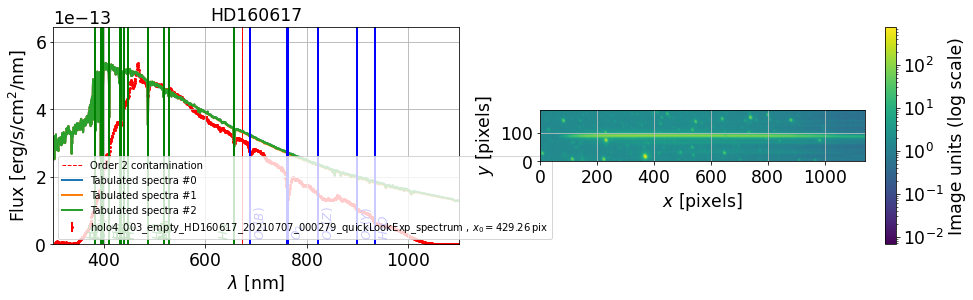

17 ) holo4_003_empty_HD160617_20210707_000280_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000280_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000280_quickLookExp_spectrum.fits


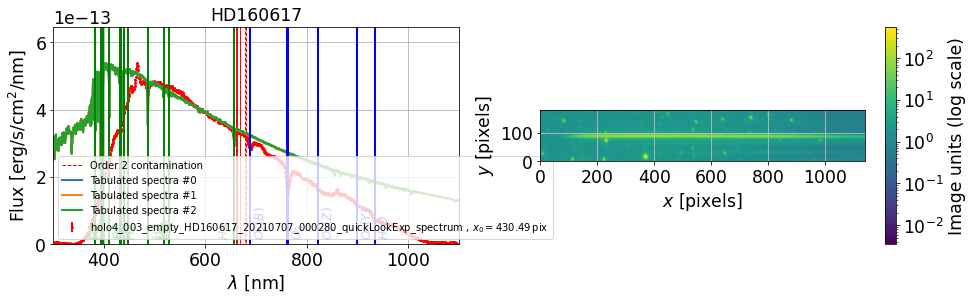

18 ) holo4_003_empty_HD160617_20210707_000282_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000282_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000282_quickLookExp_spectrum.fits


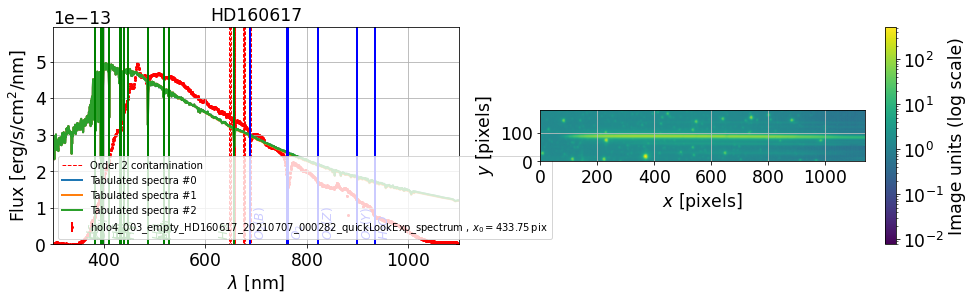

19 ) holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000284_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits


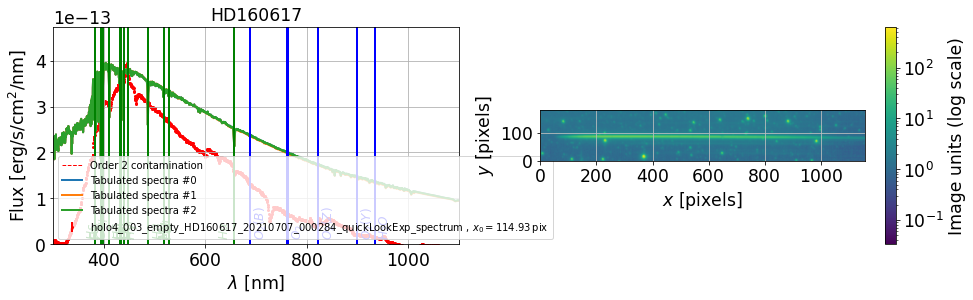

20 ) holo4_003_empty_HD160617_20210707_000285_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000285_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000285_quickLookExp_spectrum.fits


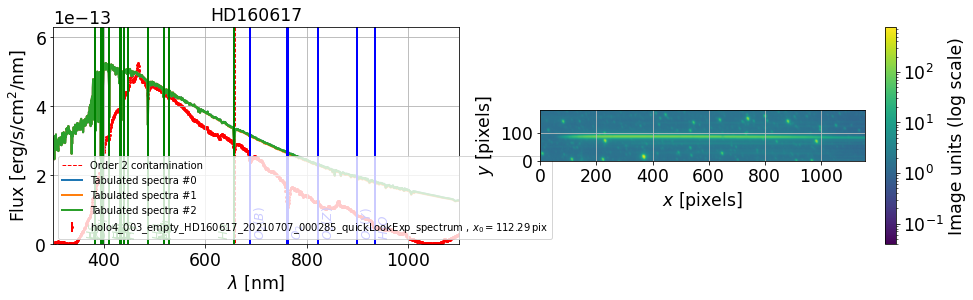

21 ) holo4_003_empty_HD160617_20210707_000286_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000286_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000286_quickLookExp_spectrum.fits


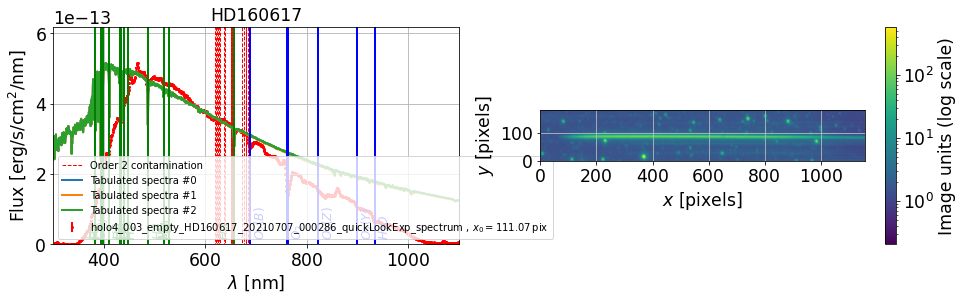

22 ) holo4_003_empty_HD160617_20210707_000287_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000287_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000287_quickLookExp_spectrum.fits


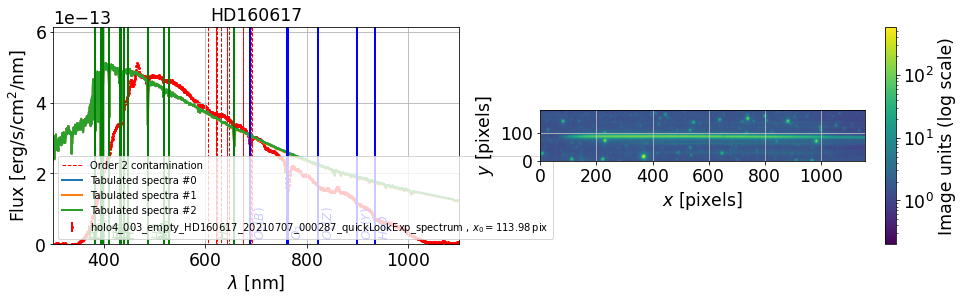

23 ) holo4_003_empty_HD160617_20210707_000288_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000288_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000288_quickLookExp_spectrum.fits


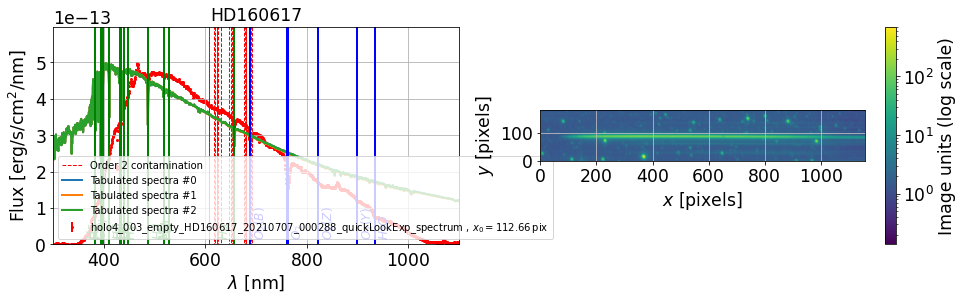

24 ) holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000289_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits


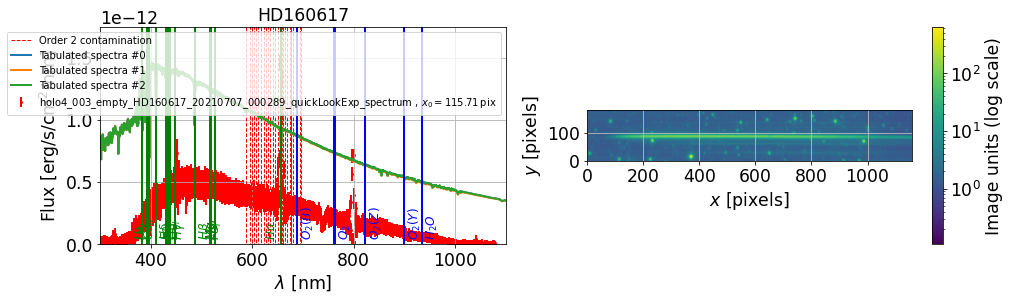

25 ) holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000290_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000290_quickLookExp_spectrum.fits


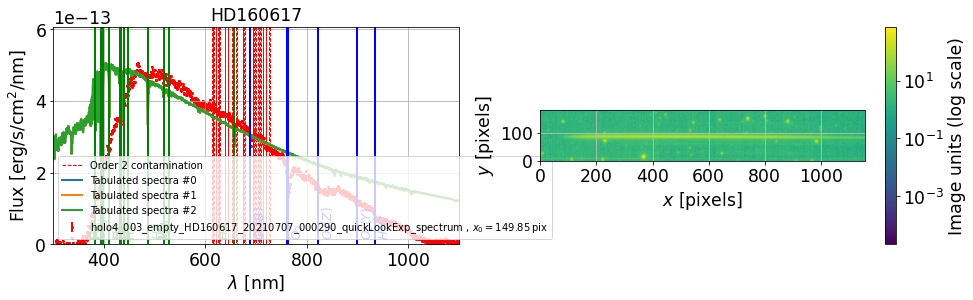

26 ) holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000291_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits


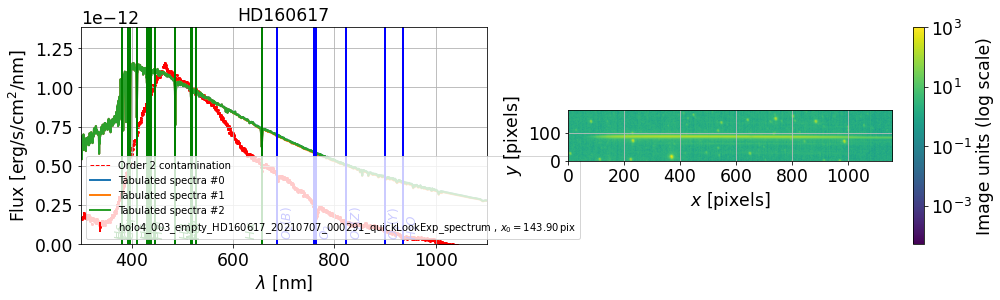

27 ) holo4_003_empty_HD160617_20210707_000296_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000296_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000296_quickLookExp_spectrum.fits


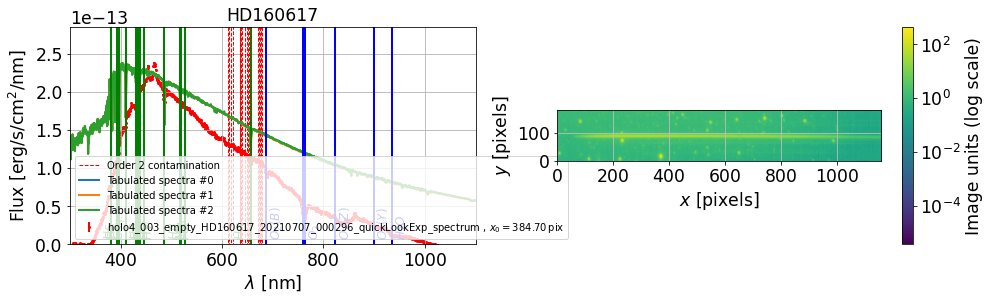

28 ) holo4_003_empty_HD160617_20210707_000297_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000297_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000297_quickLookExp_spectrum.fits


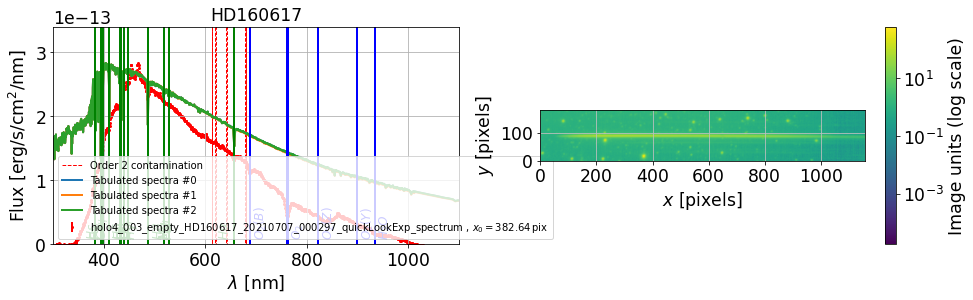

29 ) holo4_003_empty_HD160617_20210707_000298_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000298_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000298_quickLookExp_spectrum.fits


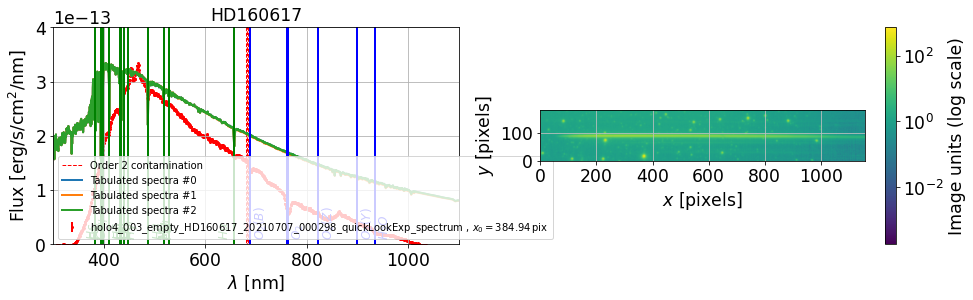

30 ) holo4_003_empty_HD160617_20210707_000303_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000303_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000303_quickLookExp_spectrum.fits


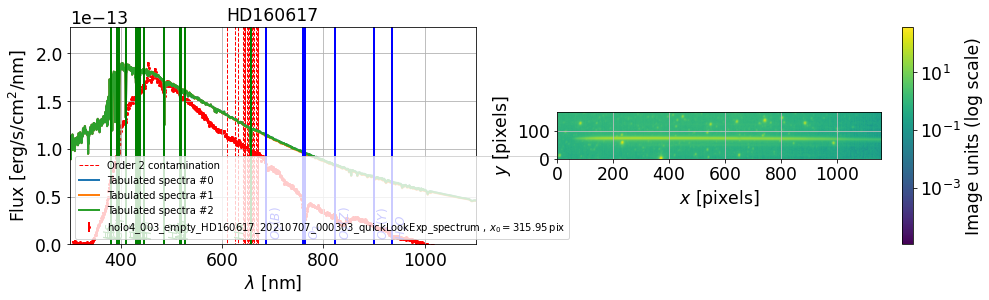

31 ) holo4_003_empty_HD160617_20210707_000304_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000304_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000304_quickLookExp_spectrum.fits


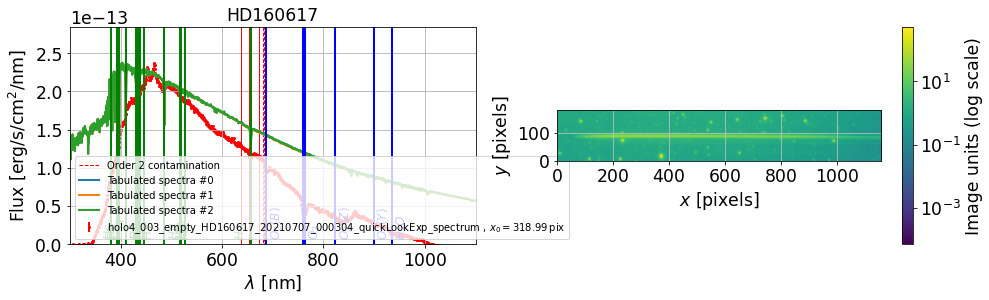

32 ) holo4_003_empty_HD160617_20210707_000305_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000305_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000305_quickLookExp_spectrum.fits


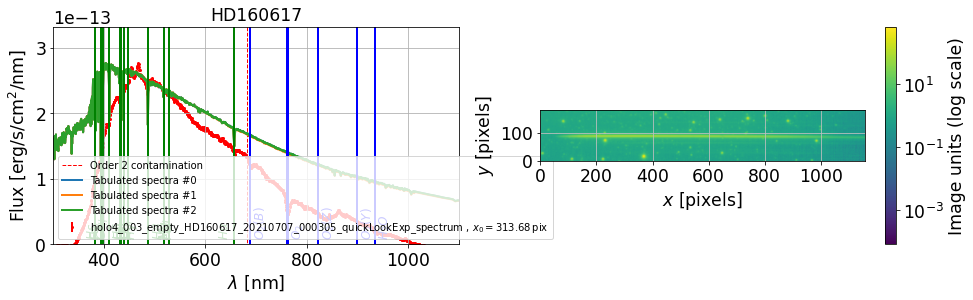

33 ) holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits


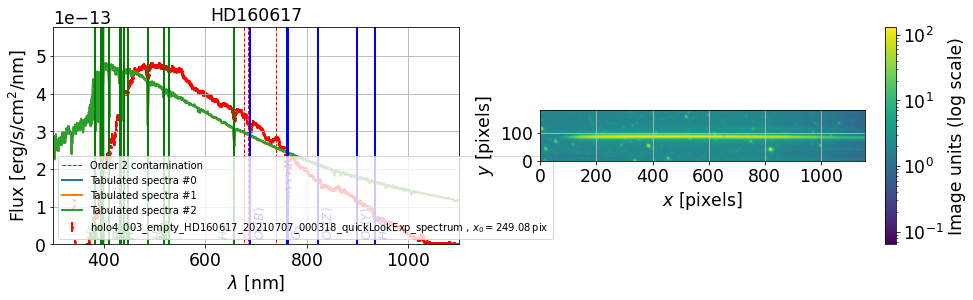

34 ) holo4_003_empty_HD160617_20210707_000319_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000319_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000319_quickLookExp_spectrum.fits


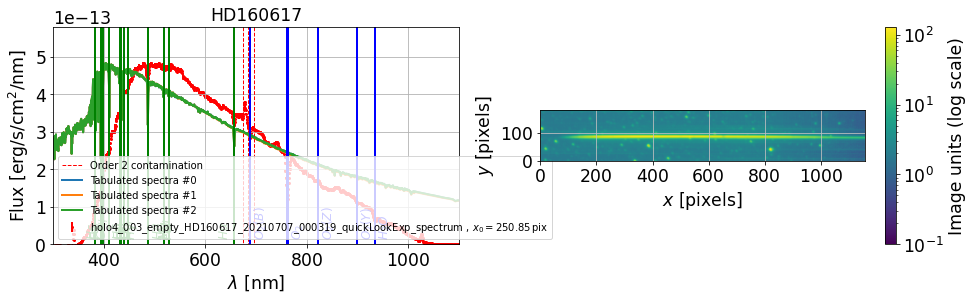

35 ) holo4_003_empty_HD160617_20210707_000320_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000320_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000320_quickLookExp_spectrum.fits


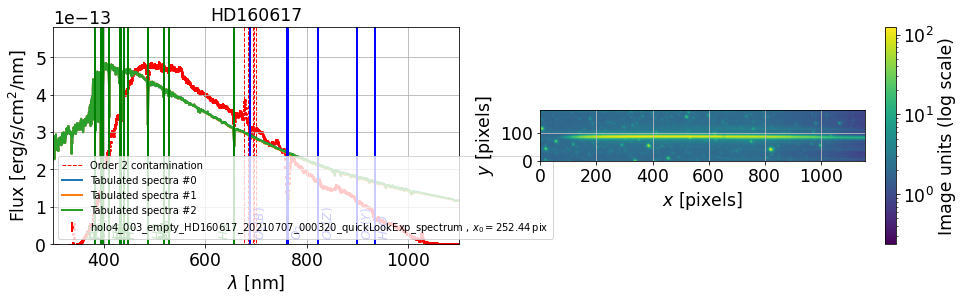

36 ) holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000321_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000321_quickLookExp_spectrum.fits


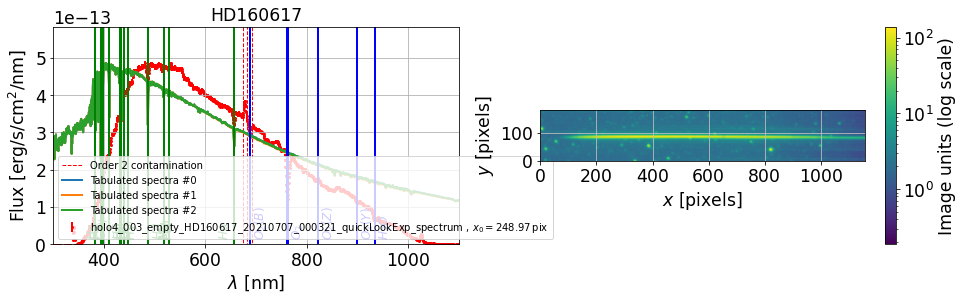

37 ) holo4_003_empty_HD160617_20210707_000322_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000322_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000322_quickLookExp_spectrum.fits


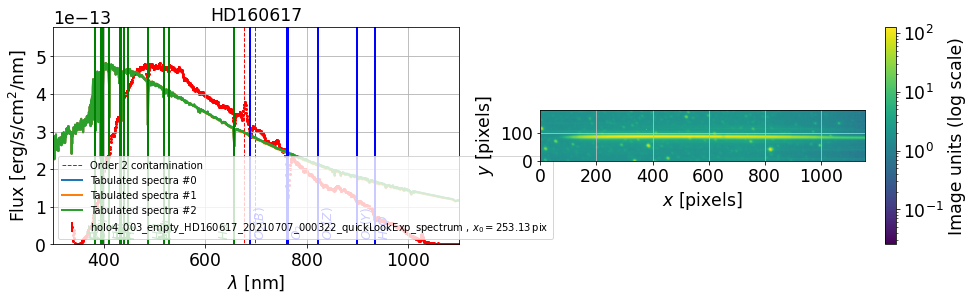

38 ) holo4_003_empty_HD160617_20210707_000323_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000323_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000323_quickLookExp_spectrum.fits


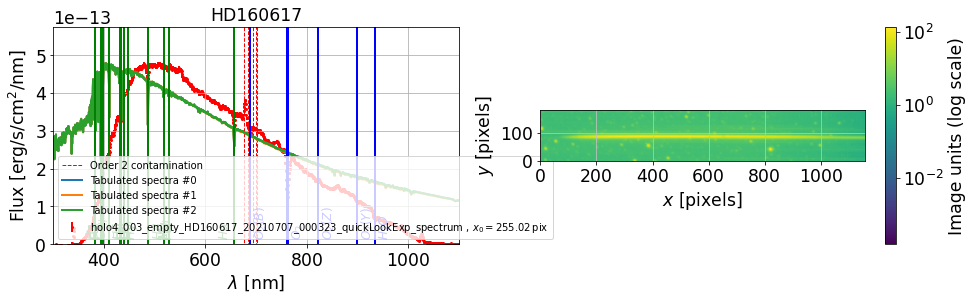

39 ) holo4_003_empty_HD160617_20210707_000324_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000324_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000324_quickLookExp_spectrum.fits


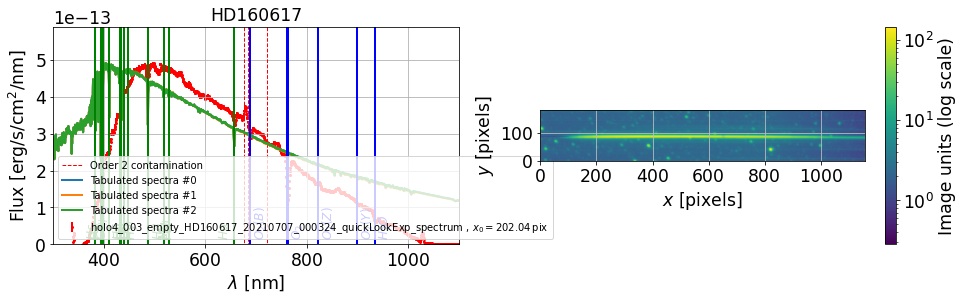

40 ) holo4_003_empty_HD160617_20210707_000325_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000325_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000325_quickLookExp_spectrum.fits


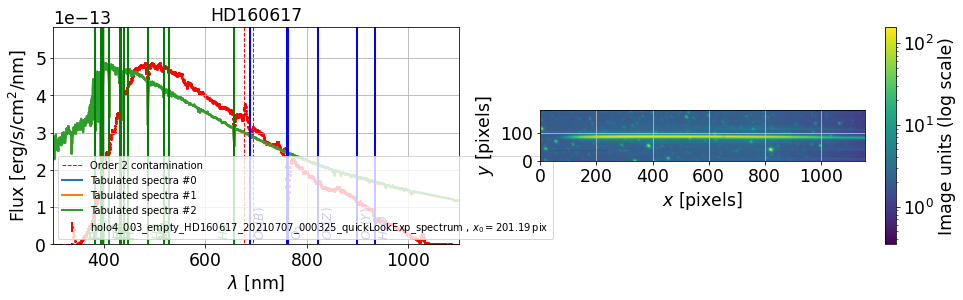

41 ) holo4_003_empty_HD160617_20210707_000326_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000326_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000326_quickLookExp_spectrum.fits


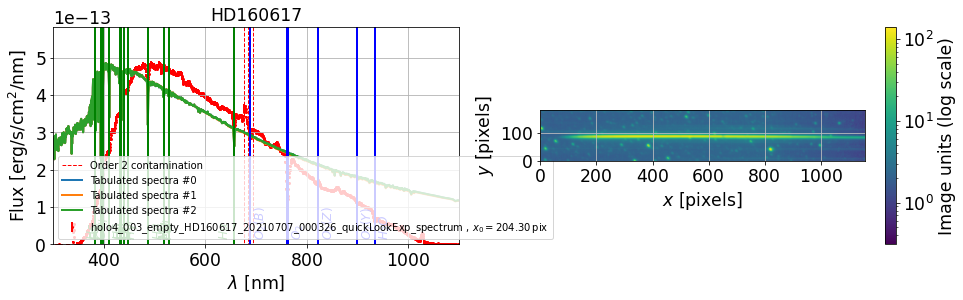

42 ) holo4_003_empty_HD160617_20210707_000328_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000328_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000328_quickLookExp_spectrum.fits


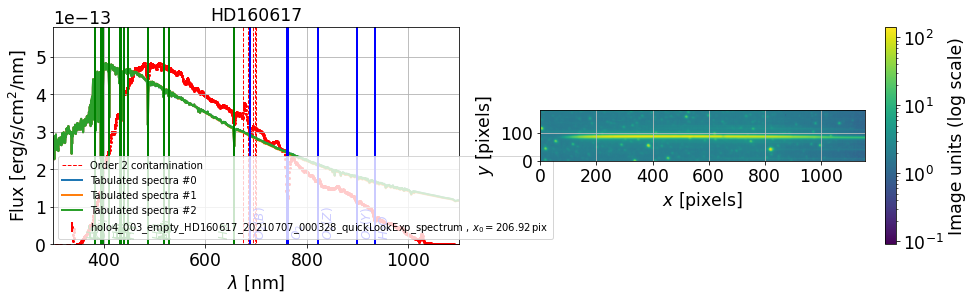

43 ) holo4_003_empty_HD160617_20210707_000329_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000329_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000329_quickLookExp_spectrum.fits


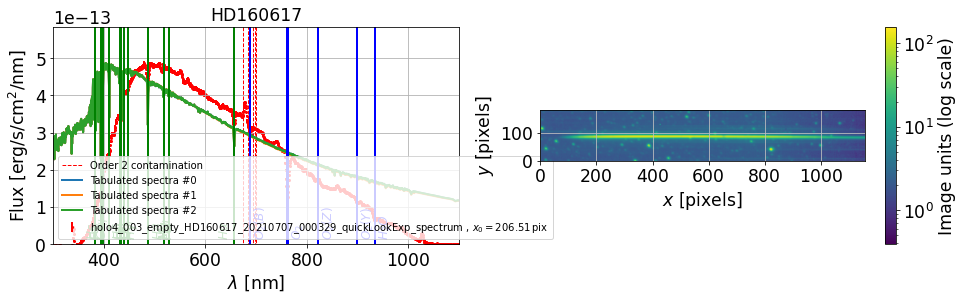

44 ) holo4_003_empty_HD160617_20210707_000330_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000330_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000330_quickLookExp_spectrum.fits


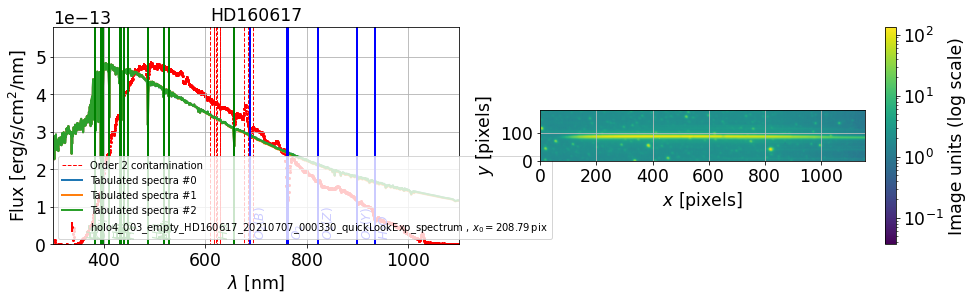

45 ) holo4_003_empty_HD160617_20210707_000331_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000331_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000331_quickLookExp_spectrum.fits


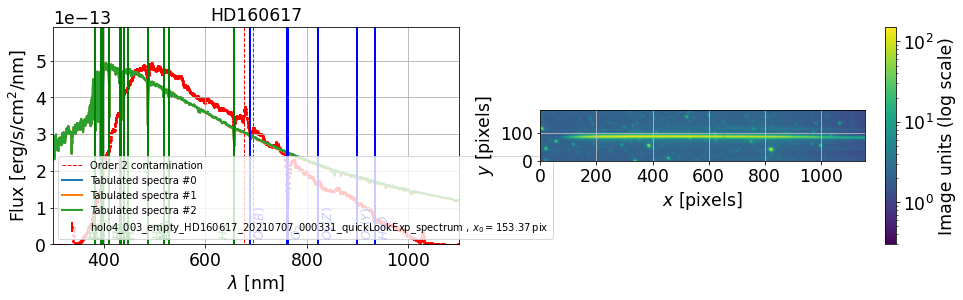

46 ) holo4_003_empty_HD160617_20210707_000332_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000332_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000332_quickLookExp_spectrum.fits


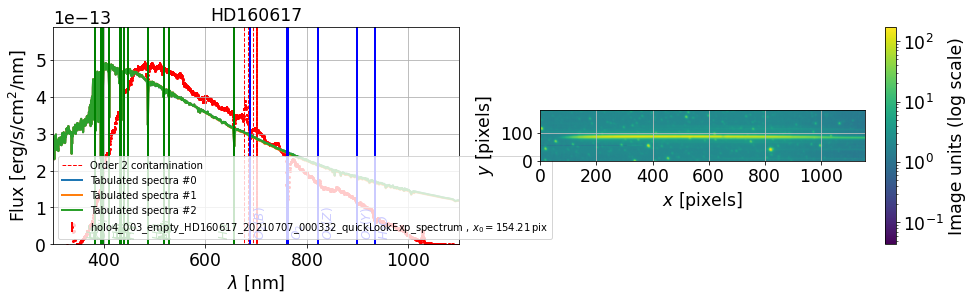

47 ) holo4_003_empty_HD160617_20210707_000334_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000334_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000334_quickLookExp_spectrum.fits


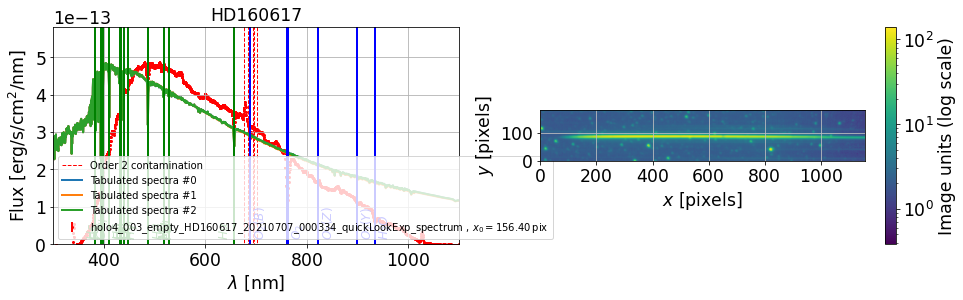

48 ) holo4_003_empty_HD160617_20210707_000335_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000335_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000335_quickLookExp_spectrum.fits


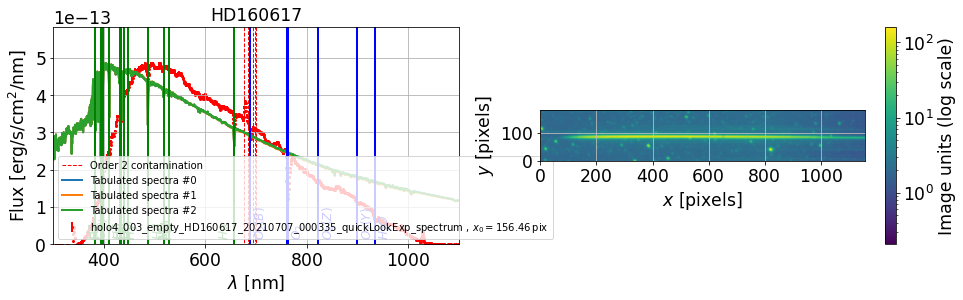

49 ) holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000336_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000336_quickLookExp_spectrum.fits


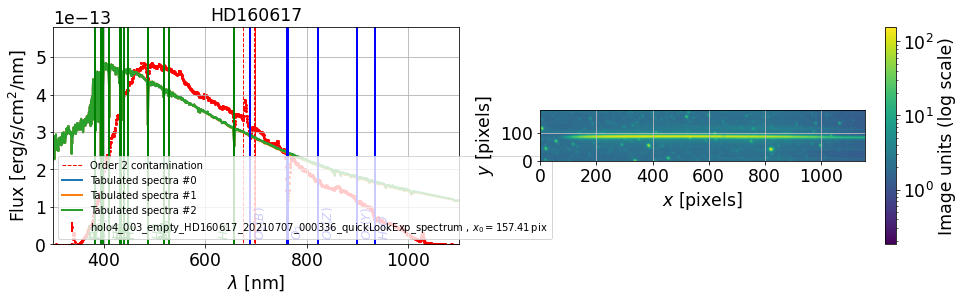

50 ) holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000337_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000337_quickLookExp_spectrum.fits


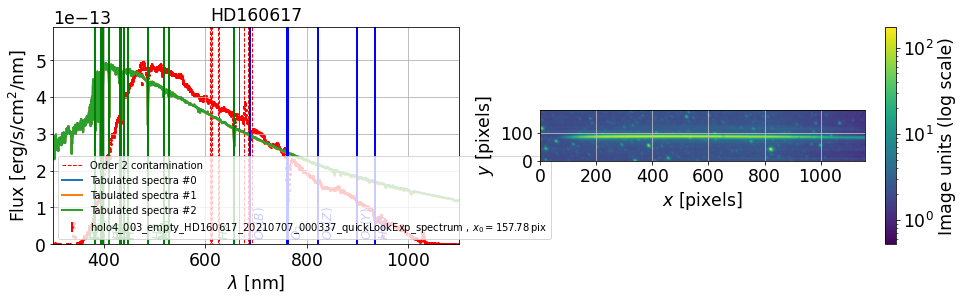

51 ) holo4_003_empty_HD160617_20210707_000338_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000338_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000338_quickLookExp_spectrum.fits


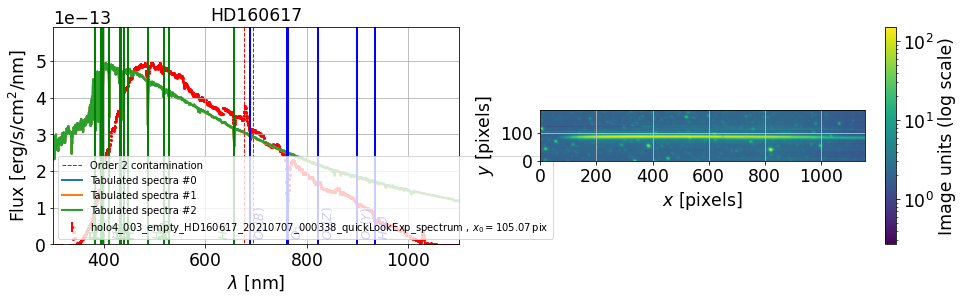

52 ) holo4_003_empty_HD160617_20210707_000339_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000339_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000339_quickLookExp_spectrum.fits


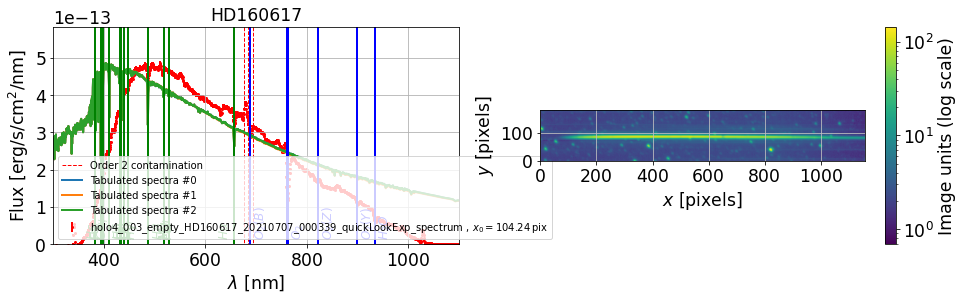

53 ) holo4_003_empty_HD160617_20210707_000340_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000340_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000340_quickLookExp_spectrum.fits


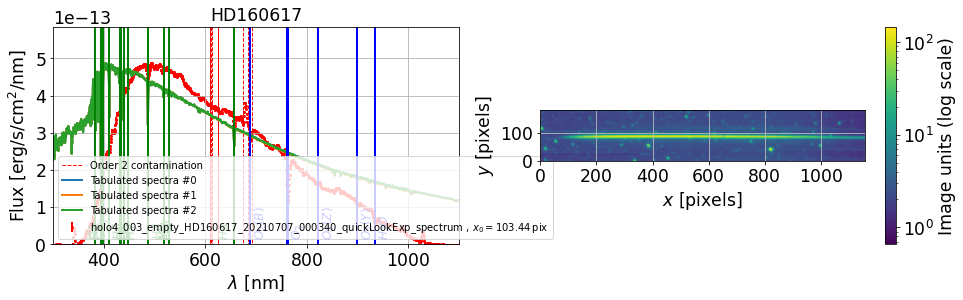

54 ) holo4_003_empty_HD160617_20210707_000341_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000341_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000341_quickLookExp_spectrum.fits


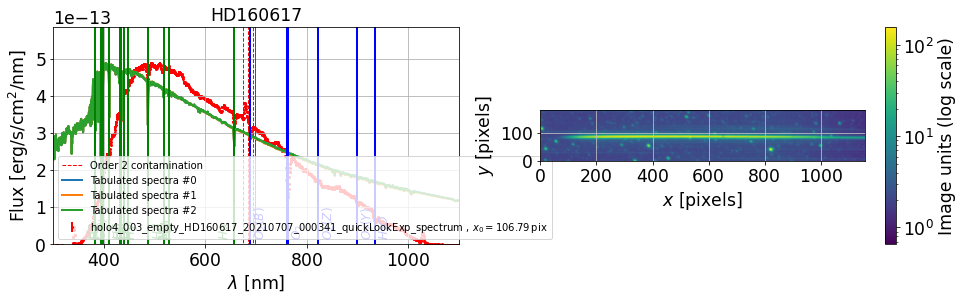

55 ) holo4_003_empty_HD160617_20210707_000342_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000342_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000342_quickLookExp_spectrum.fits


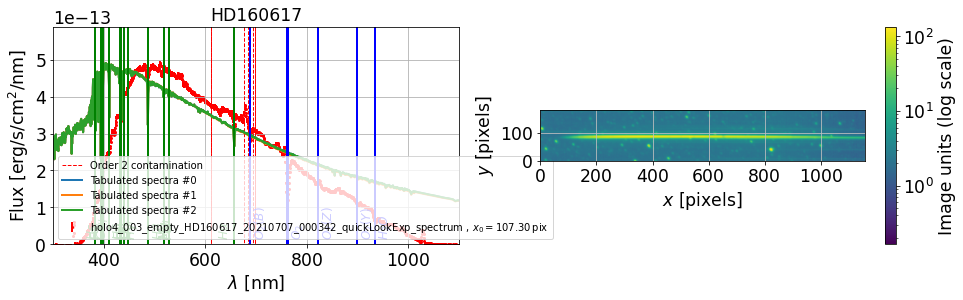

56 ) holo4_003_empty_HD160617_20210707_000343_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000343_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000343_quickLookExp_spectrum.fits


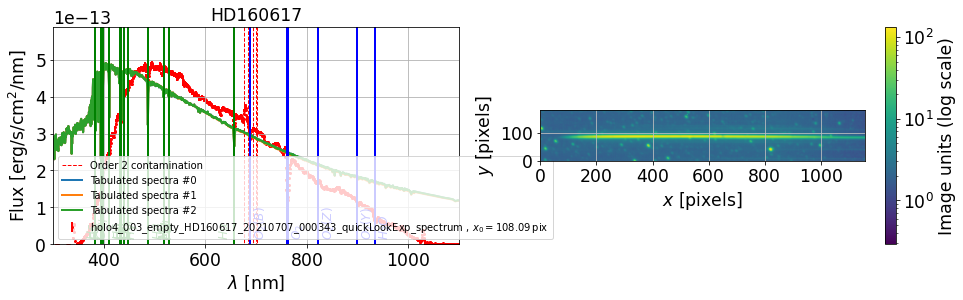

57 ) holo4_003_empty_HD160617_20210707_000344_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000344_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000344_quickLookExp_spectrum.fits


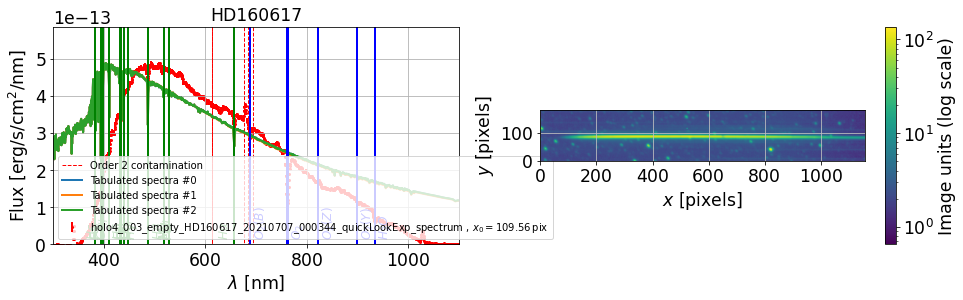

58 ) holo4_003_empty_HD160617_20210707_000345_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000345_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000345_quickLookExp_spectrum.fits


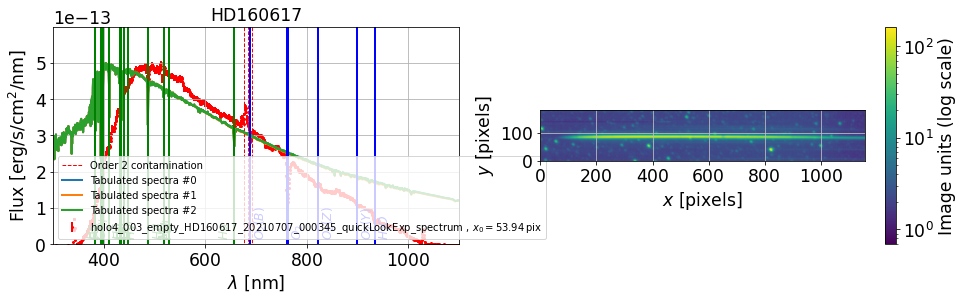

59 ) holo4_003_empty_HD160617_20210707_000346_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000346_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000346_quickLookExp_spectrum.fits


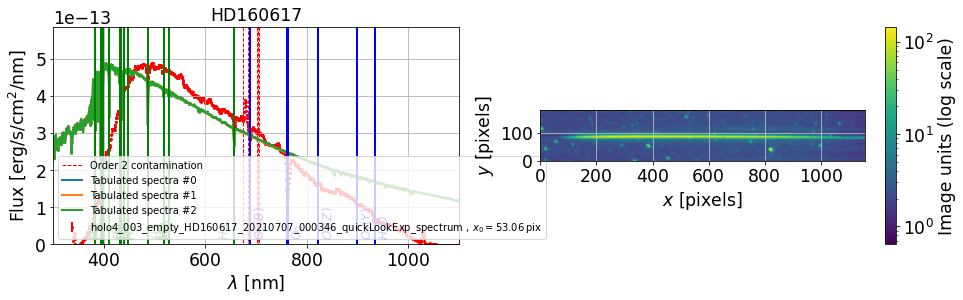

60 ) holo4_003_empty_HD160617_20210707_000347_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000347_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000347_quickLookExp_spectrum.fits


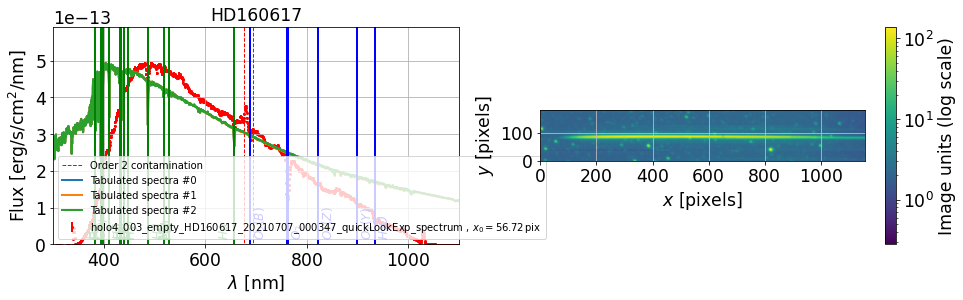

61 ) holo4_003_empty_HD160617_20210707_000348_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000348_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000348_quickLookExp_spectrum.fits


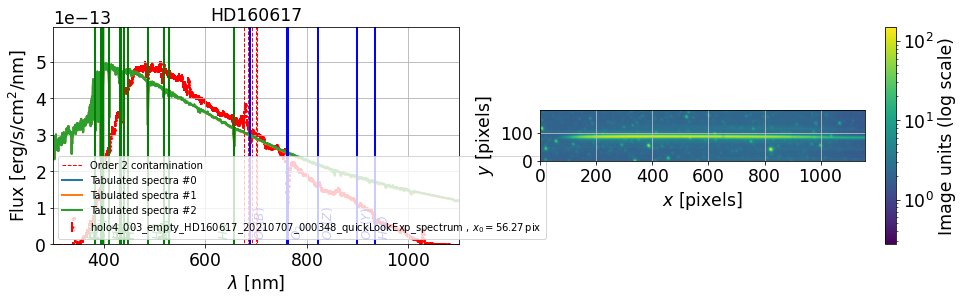

62 ) holo4_003_empty_HD160617_20210707_000349_quickLookExp_spectrum.fits   /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000349_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000349_quickLookExp_spectrum.fits


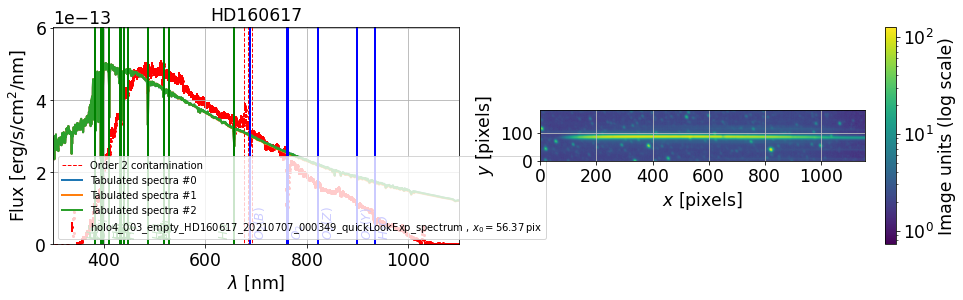

In [46]:
parameters.DISPLAY=False

infos = []
all_lambdas=[]
all_data=[]
all_num=[]

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

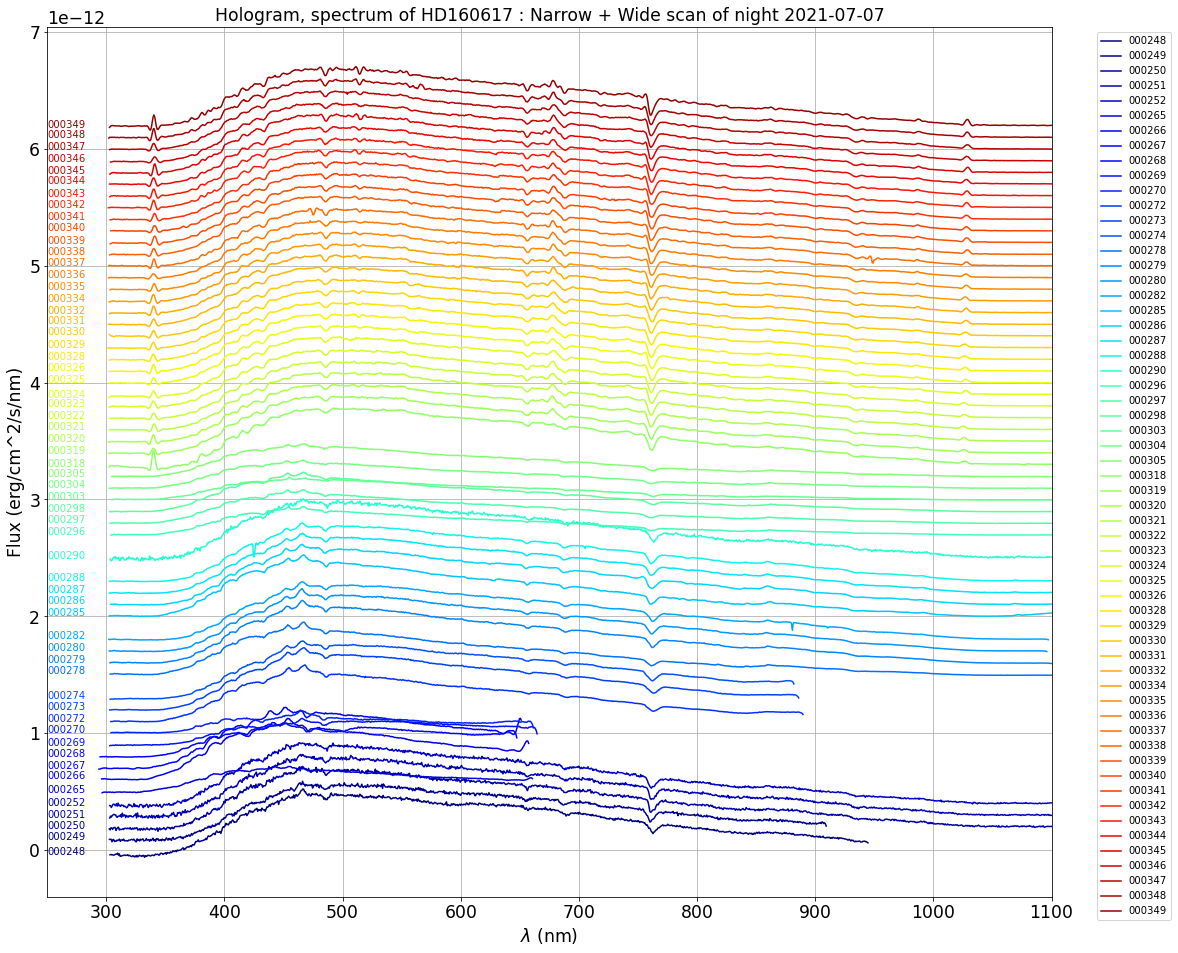

In [47]:
fig=plt.figure(figsize=(18,16))
ax=fig.add_subplot(1,1,1)

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename= os.path.basename(fullfilename)
         
    #s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label=all_num[idx]
    
    
    
    delta=idx*1.0e-13
    #delta=0
    
    if label not in ["000284","000276","000289","000291"] :
        ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        plt.text(250.,all_data[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
    
    idx+=1
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux (erg/cm^2/s/nm)")
ax.set_xlim(250.,1100)
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
ax.set_title("Hologram, spectrum of HD160617 : Narrow + Wide scan of night 2021-07-07")
plt.show()
    

# Narrow scan dataset

In [48]:
idx=0
all_num_nr = []
all_lambdas_nr = []
all_data_nr = []

for fullfilename in all_good_spectra_spectrum_files:
    
    
    if all_num[idx] >= '000317':
        all_num_nr.append(all_num[idx])
        all_lambdas_nr.append(all_lambdas[idx]) 
        all_data_nr.append(all_data[idx])
        
    idx+=1
        
    

In [49]:
def PlotSpectra(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum of HD160617 : Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
        
    
    

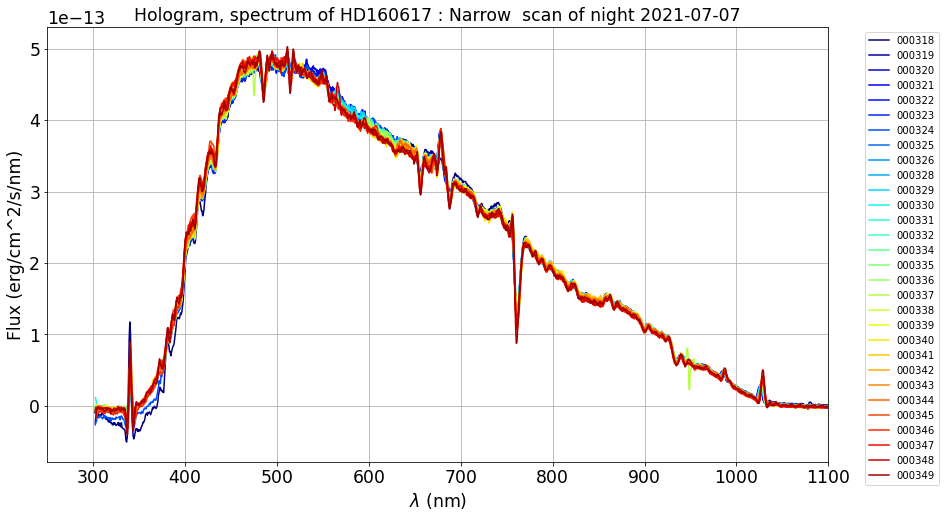

In [50]:
PlotSpectra(all_lambdas_nr,all_data_nr,all_num_nr)

In [51]:
idx=0
for num in all_num:
    if num == "000335":
        print(idx," ",num)
        idx0=idx
    idx+=1
idx0

48   000335


48

In [52]:
idx=0
for num in all_num_nr:
    if num == "000335":
        print(idx," ",num)
        idx0=idx
    idx+=1
idx0

15   000335


15

In [53]:
idx_ref=15

In [54]:
from scipy.signal import savgol_filter

In [55]:
wl=np.arange(380,1000)

In [56]:
all_lambdas[idx0]

array([ 303.36456375,  304.07441593,  304.78425723, ..., 1100.72544548,
       1101.40679145, 1102.0880993 ])

In [57]:
ref=np.interp(wl, all_lambdas[idx_ref],all_data[idx_ref])

In [58]:
yhat = savgol_filter(ref, 11, 3) # window size 51, polynomial order 3

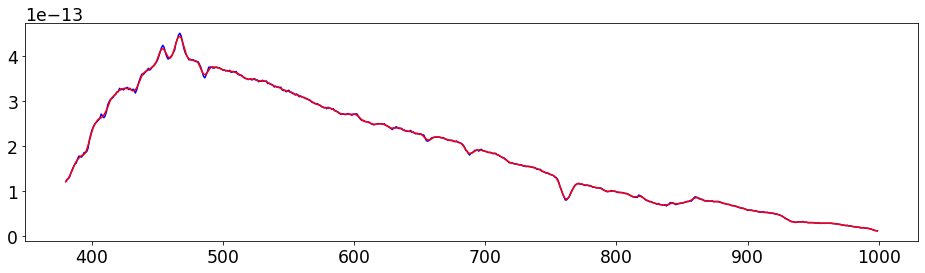

In [59]:
plt.plot(wl,ref,'b-')
plt.plot(wl,yhat,'r-')

In [60]:
def PlotFilteredRatio(all_wl,all_spec,all_tag,idx_ref,window=11, 
                thetitle="Hologram, spectrum of HD160617 : Spectrum ratio Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="spectrum ratio",figsize=(14,8)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    wl=np.arange(380,1000)
   
    # filter    
    ref_filt = savgol_filter(all_spec[idx_ref], window, 3) # window size 11, polynomial order 3
    # interpolate
    ref_int= np.interp(wl, all_wl[idx_ref],ref_filt)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        
        spec_filt = savgol_filter(all_spec[idx], window, 3) # window size 11, polynomial order 3
        spec_int = np.interp(wl, all_wl[idx],spec_filt)
        
        ratiof = spec_int/ref_int
        
        ax.plot(wl,ratiof,label=label,color=all_colors[idx])
       
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(380.,1000)
    ax.set_ylim(0.9,1.1)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    

In [61]:
refnum=all_num_nr[idx_ref]
thetitle=f"Hologram, target HD160617 : spectrum ratio , narrow scan , night 2021-07-07, ref {refnum}"

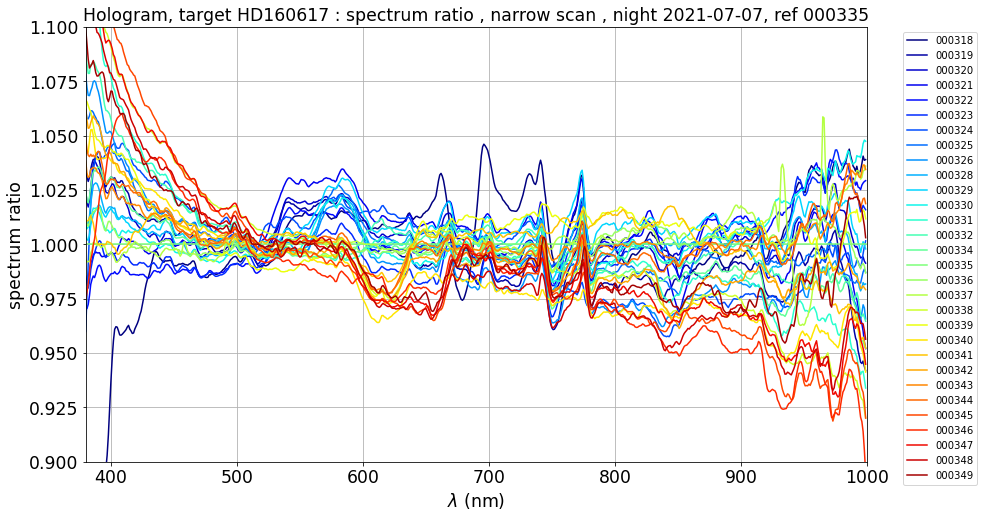

In [62]:
PlotFilteredRatio(all_lambdas_nr,all_data_nr,all_num_nr,idx_ref,window=51,thetitle=thetitle)

### Select a ring around the reference

In [63]:
all_num_nr=np.array(all_num_nr)

In [64]:
ring_num = np.array(['000335','000328','000329','000334','000336','000341','000342','000343'])
ring_num

array(['000335', '000328', '000329', '000334', '000336', '000341',
       '000342', '000343'], dtype='<U6')

In [65]:
indexes_ring=[ np.where(all_num_nr==idx)[0][0] for idx in  ring_num]

In [66]:
all_lambdas_ring=[all_lambdas_nr[idx] for idx in indexes_ring]
all_data_ring =  [all_data_nr[idx] for idx in indexes_ring]
all_num_ring = [all_num_nr[idx] for idx in indexes_ring]

In [67]:
idx_ref=0
refnum=all_num_ring[idx_ref]
thetitle=f"Hologram, target HD160617 : central ring , night 2021-07-07, ref {refnum}"

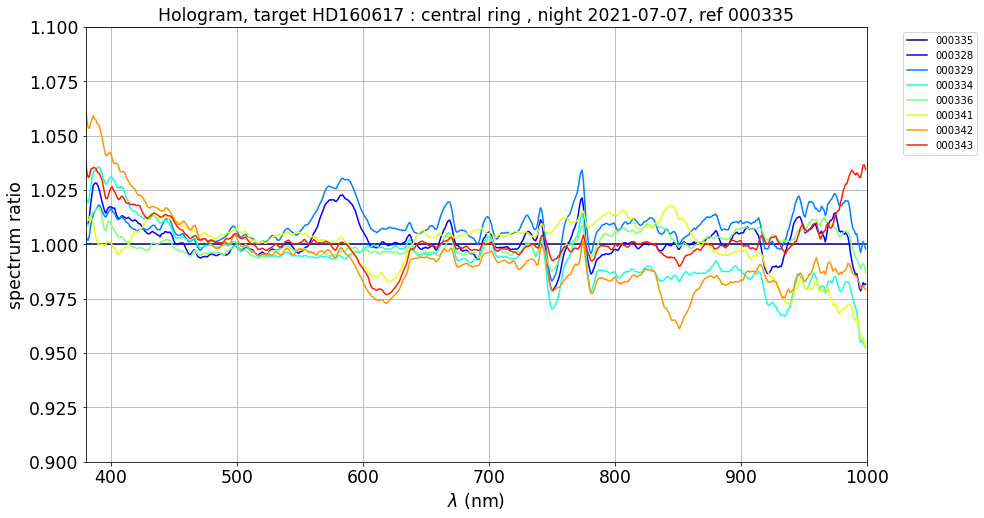

In [68]:
PlotFilteredRatio(all_lambdas_ring,all_data_ring,all_num_ring,idx_ref,window=51,thetitle=thetitle)

In [69]:
infos[0]

[0, '2021-07-08T03:13:52.977', 1.015855579774225, 12.1, 742.55, 5.0]

In [70]:
infos[-1]

[62, '2021-07-08T05:06:31.848', 1.089454227205665, 12.5, 742.25, 6.0]

# Some reconstructions values in header

In [71]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    chi2_fit=header["CHI2_FIT"]
    a2_fit=header["A2_FIT"]
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

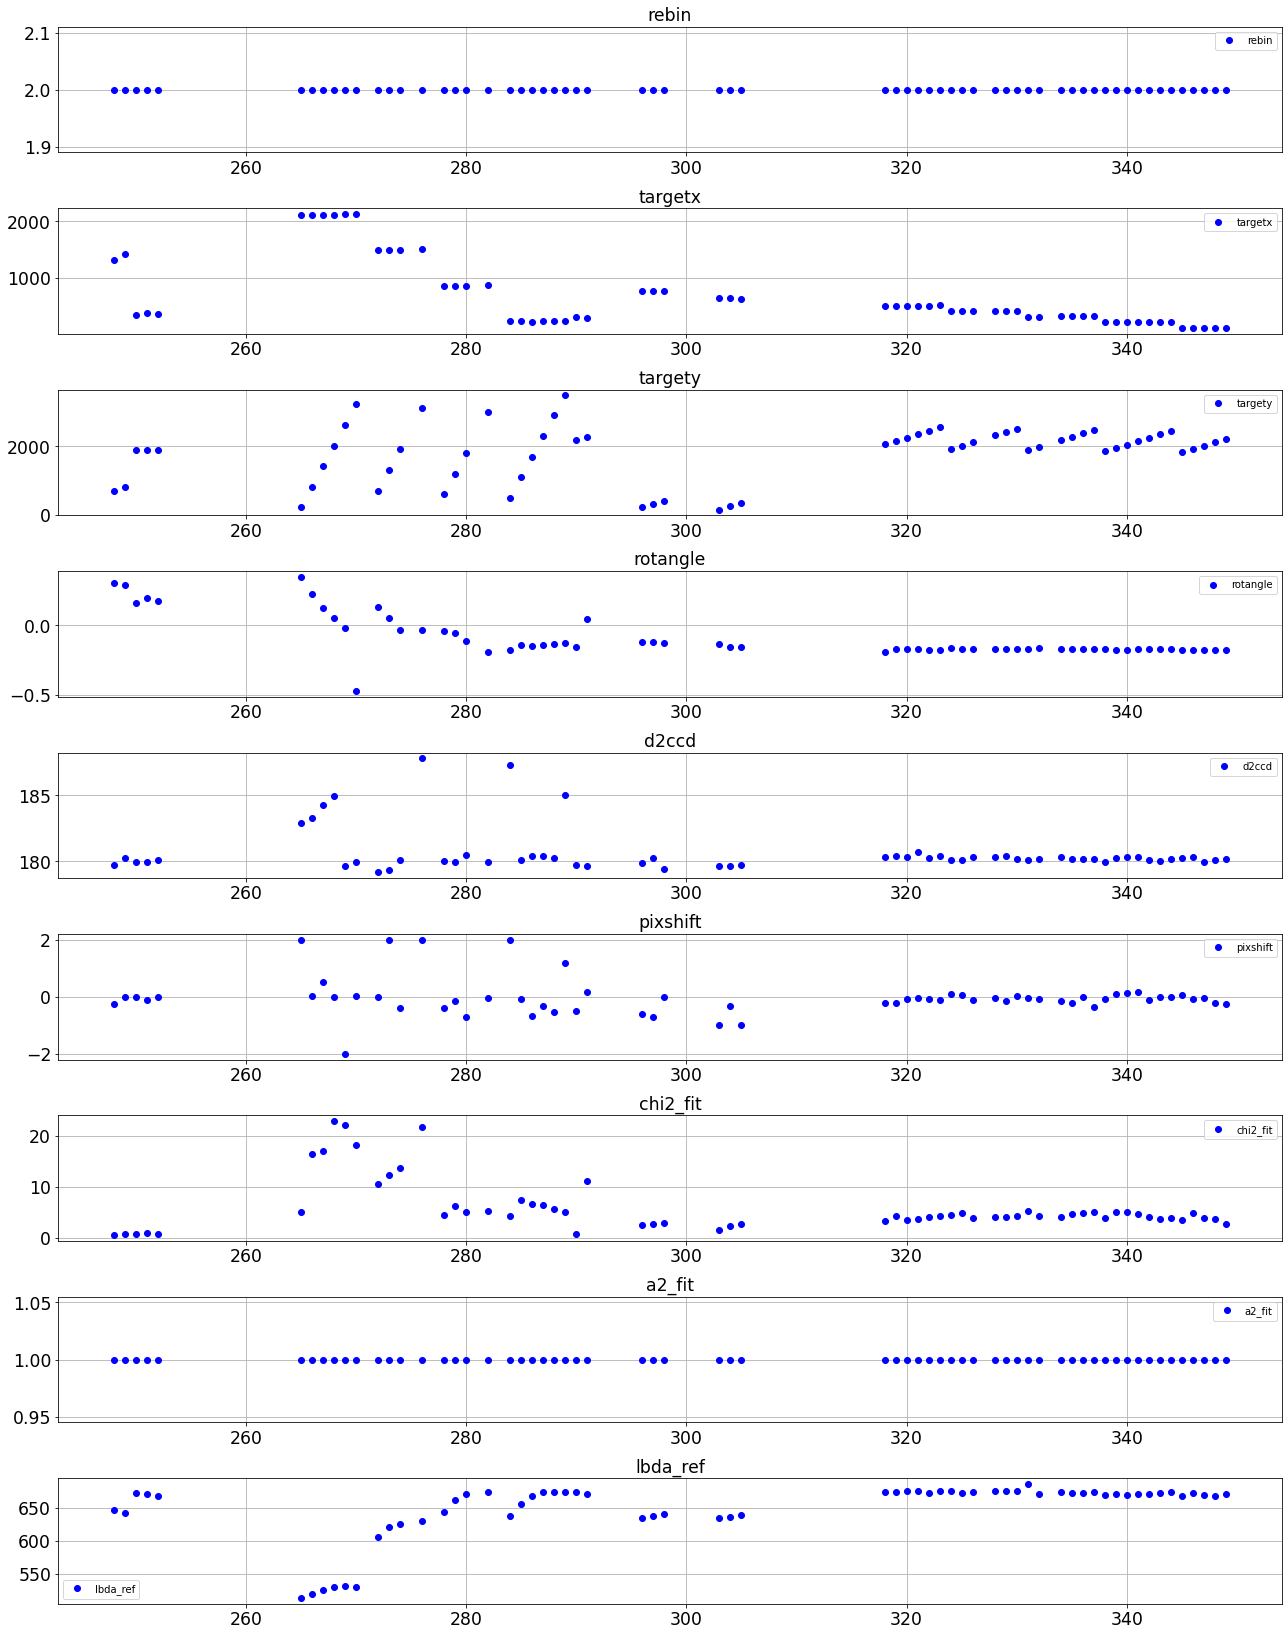

In [72]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"bo",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"bo",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"bo",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"bo",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"bo",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"bo",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"bo",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"bo",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")


plt.tight_layout()

# Find bad reconstructions

<ipython-input-73-053a3037a583>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=fig.add_subplot(1,2,1)


Text(0.5, 1.0, 'Distance holo-CCD')

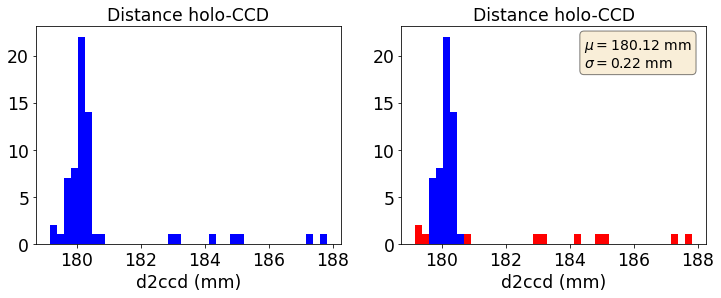

In [73]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.hist(all_d2ccd,bins=40,facecolor="blue")
ax.set_xlabel("d2ccd (mm)")

ax=fig.add_subplot(1,2,1)

arg_bad=np.where(abs(all_d2ccd-180)>0.5)[0]
list_bad=all_tagnumber[arg_bad]
ax.set_title("Distance holo-CCD")

ax=fig.add_subplot(1,2,2)
# indexes of elements in tag that are in list_bad
arg_badindexes=np.where(np.in1d(all_tagnumber, list_bad))
# indexes of elements in tag that are NOT in list_bad
arg_goodindexes=np.where(np.in1d(all_tagnumber,np.setdiff1d(all_tagnumber, list_bad)))

DCCD_avr = np.mean(all_d2ccd[arg_goodindexes])
DCCD_std = np.std(all_d2ccd[arg_goodindexes])

textstr = '\n'.join((
    r'$\mu=%.2f$ mm' % (DCCD_avr, ),
    r'$\sigma=%.2f$ mm' % (DCCD_std, )))


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#props = dict(boxstyle='round')

# place a text box in upper left in axes coords
ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)





ax.hist(all_d2ccd,bins=40,facecolor="blue")
ax.hist(all_d2ccd[arg_badindexes],bins=40,facecolor="red")
ax.set_xlabel("d2ccd (mm)")
ax.set_title("Distance holo-CCD")




## Good value for DCCD

In [74]:
np.mean(all_d2ccd[arg_goodindexes])

180.1213612350383

In [75]:
np.std(all_d2ccd[arg_goodindexes])

0.22184643922399092

In [76]:
def plotbad(arg_badindexes):
    
    fig=plt.figure(figsize=(18,25))

    # rebin
    ax=fig.add_subplot(10,1,1)
    ax.plot(all_tagnumber,all_rebin,"bo",label="rebin")
    ax.plot(all_tagnumber[arg_badindexes],all_rebin[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("rebin")

    #targetx
    ax=fig.add_subplot(10,1,2)
    ax.plot(all_tagnumber,all_targetx,"bo",label="targetx")
    ax.plot(all_tagnumber[arg_badindexes],all_targetx[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("targetx")



    #targety
    ax=fig.add_subplot(10,1,3)
    ax.plot(all_tagnumber,all_targety,"bo",label="targety")
    ax.plot(all_tagnumber[arg_badindexes],all_targety[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("targety")



    #rotangle
    ax=fig.add_subplot(10,1,4)
    ax.plot(all_tagnumber,all_rotangle,"bo",label="rotangle")
    ax.plot(all_tagnumber[arg_badindexes],all_rotangle[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("rotangle")

    #d2ccd
    ax=fig.add_subplot(10,1,5)
    ax.plot(all_tagnumber,all_d2ccd,"bo",label="d2ccd")
    ax.plot(all_tagnumber[arg_badindexes],all_d2ccd[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("d2ccd")


    #pixshift
    ax=fig.add_subplot(10,1,6)
    ax.plot(all_tagnumber,all_pixshift,"bo",label="pixshift")
    ax.plot(all_tagnumber[arg_badindexes],all_pixshift[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("pixshift")


    #chi2_fit
    ax=fig.add_subplot(10,1,7)
    ax.plot(all_tagnumber,all_chi2_fit,"bo",label="chi2_fit")
    ax.plot(all_tagnumber[arg_badindexes],all_chi2_fit[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("chi2_fit")

    #a2_fit
    ax=fig.add_subplot(10,1,8)
    ax.plot(all_tagnumber,all_a2_fit,"bo",label="a2_fit")
    ax.plot(all_tagnumber[arg_badindexes],all_a2_fit[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("a2_fit")


    #all_lbda_ref
    ax=fig.add_subplot(10,1,9)
    ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
    ax.plot(all_tagnumber[arg_badindexes],all_lbda_ref[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("lbda_ref")


    plt.tight_layout()
    

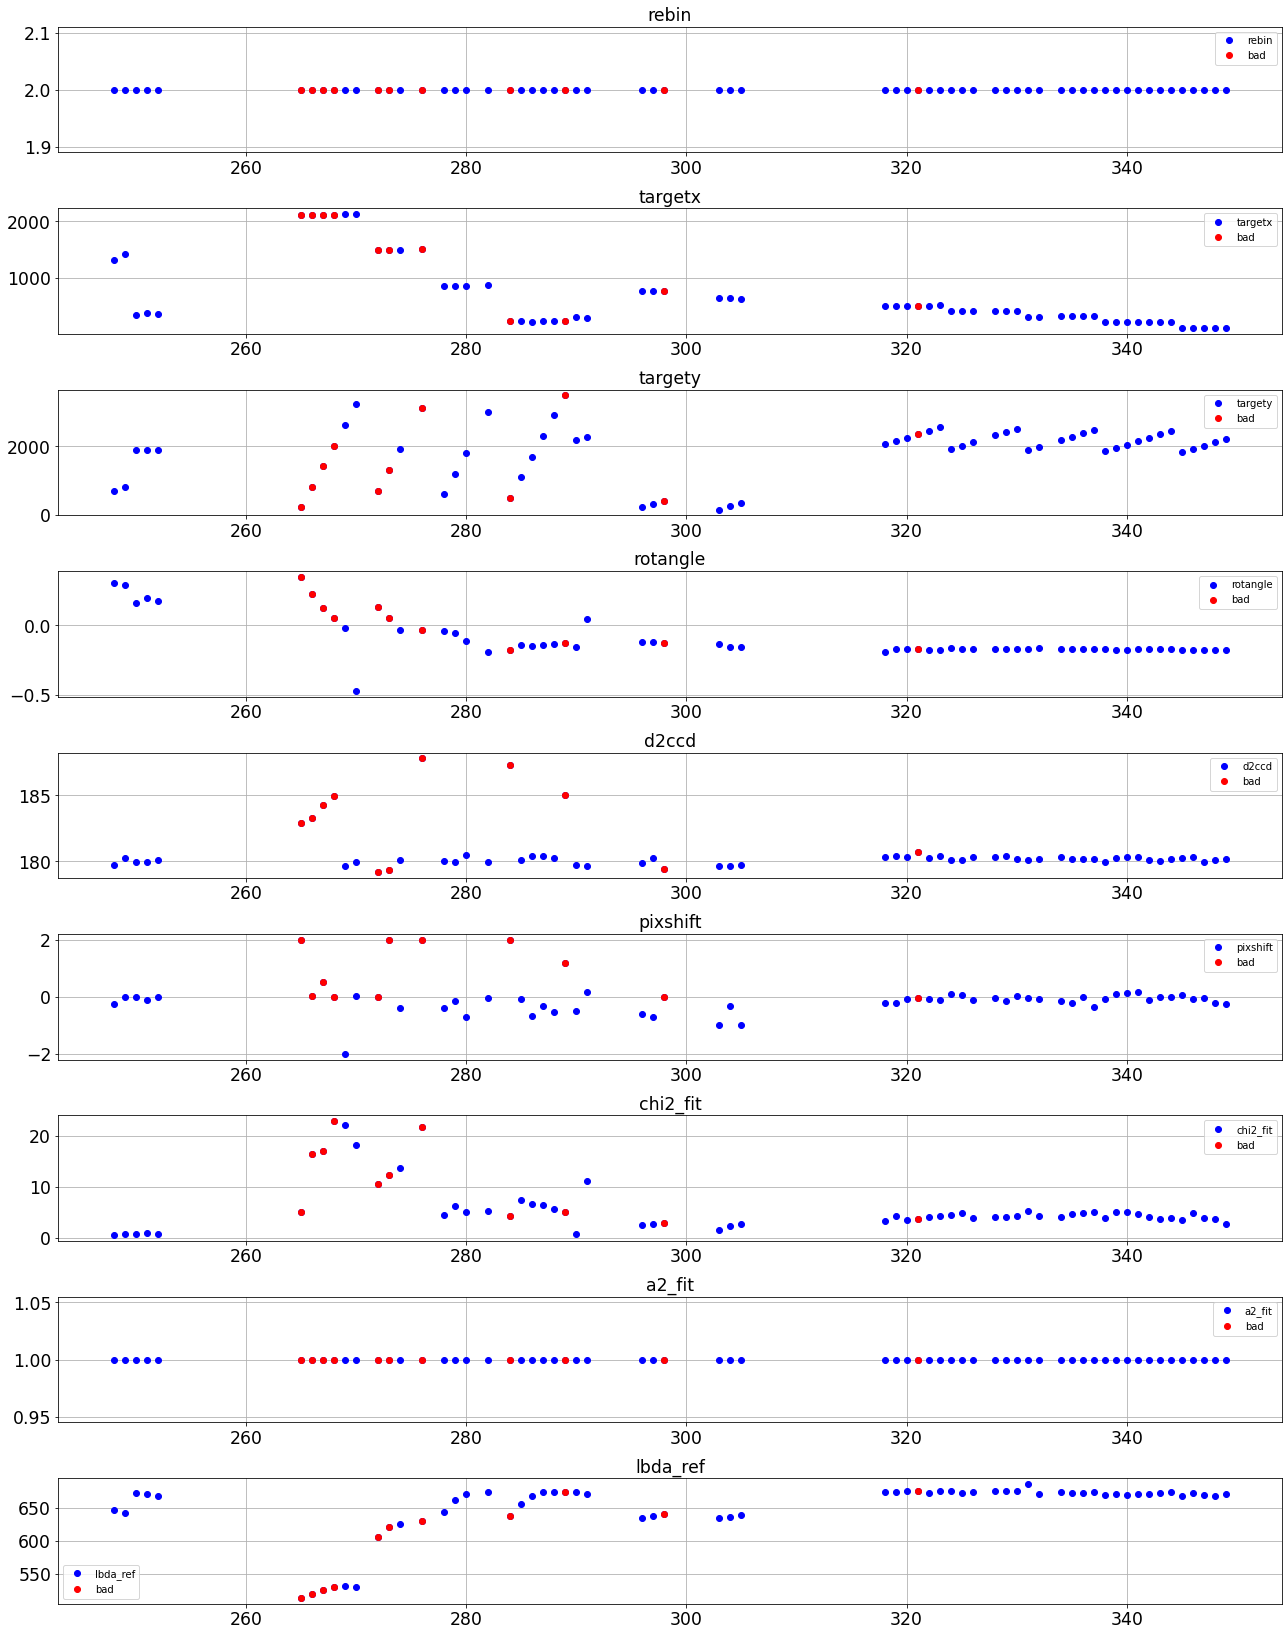

In [77]:
plotbad(arg_badindexes)

# List of bad Spectra

In [78]:
print("list of bad Spectra : ",list_bad)

list of bad Spectra :  [265. 266. 267. 268. 272. 273. 276. 284. 289. 298. 321.]


# Selection of the spectrum


This is an example to show how to access to information on reconstructed spectra

In [79]:
IDXSEL=33

In [80]:
all_good_spectra_spectrum_files[IDXSEL]

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits'

In [81]:
fullfilename_SEL=all_good_spectra_spectrum_files[IDXSEL]
fullfilename_spectrogram_SEL=fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL=fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL=fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [82]:
filename_SEL = os.path.basename(fullfilename_SEL)
filename_spectrogram_SEL = os.path.basename(fullfilename_spectrogram_SEL)
filename_lines_SEL = os.path.basename(fullfilename_lines_SEL)
filename_table_SEL = os.path.basename(fullfilename_table_SEL)

## Spectrum

In [83]:
spectrum_hdu=fits.open(fullfilename_SEL)

In [84]:
spectrum_hdu.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRUM      1 PrimaryHDU     146   (1158, 3)   float64   
  1  SPEC_COV      1 ImageHDU         8   (1158, 1158)   float64   
  2  ORDER2        1 ImageHDU         8   (1158, 3)   float64   
  3  ORDER0        1 ImageHDU        10   (50, 43)   float64   


In [85]:
spectrum_hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1158                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-07-08T04:49:50.137'                                             
DATE-OBS= '2021-07-08T04:49:50.137'                                             
DATE-BEG= '2021-07-08T04:50:04.270'                                             
DATE-END= '2021-07-08T04:50:24.505'                                             
MJD     =     59403.20127473

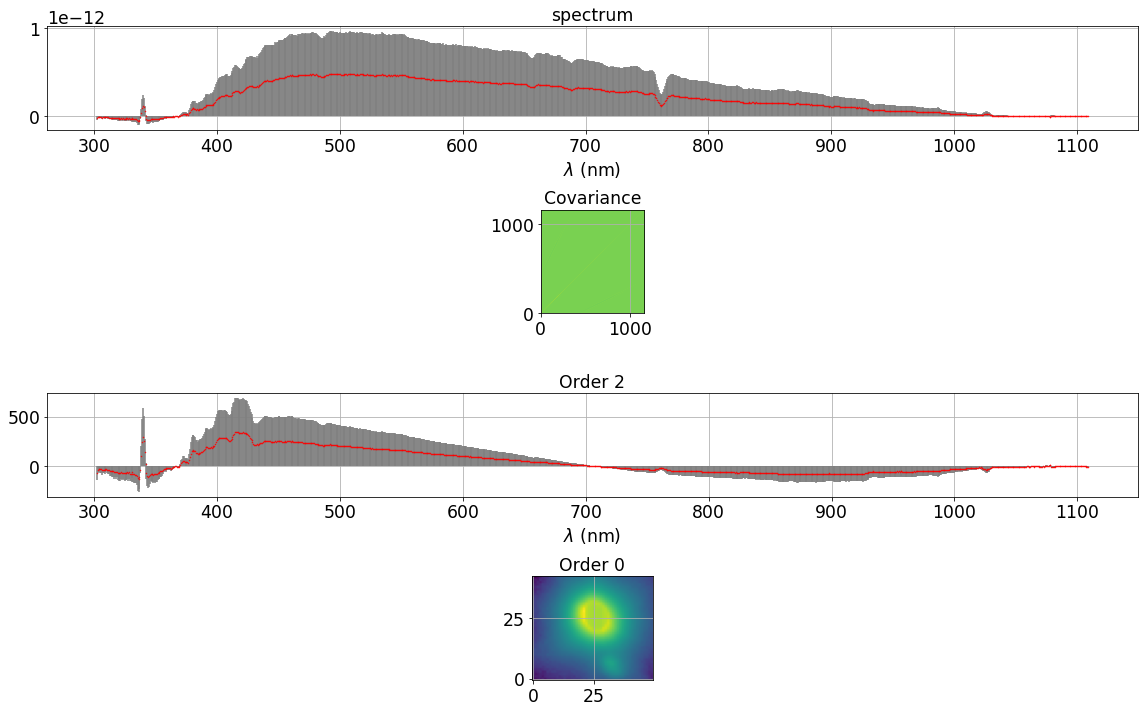

In [86]:
fig=plt.figure(figsize=(16,10))

# Spectrum
ax=fig.add_subplot(4,1,1)
x=spectrum_hdu[0].data[0,:]
y=spectrum_hdu[0].data[1,:]
yerr=spectrum_hdu[0].data[1,:]
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=0.5,color="r",ecolor="gray")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("spectrum")
ax.grid()

# Covariance

from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize,LogStretch)

ax=fig.add_subplot(4,1,2)
img=spectrum_hdu[1].data

# Create an ImageNormalize object
norm = ImageNormalize(img, interval=MinMaxInterval(),stretch=LogStretch())


#ax.imshow(img,origin="lower",norm=LogNorm())
ax.imshow(img,origin="lower",norm=norm)
ax.grid()
ax.set_title("Covariance")


# Order 2
ax=fig.add_subplot(4,1,3)
x=spectrum_hdu[2].data[0,:]
y=spectrum_hdu[2].data[1,:]
yerr=spectrum_hdu[2].data[1,:]
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=0.5,color="r",ecolor="gray")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("Order 2")
ax.grid()

# ORDER0  
ax=fig.add_subplot(4,1,4)
img=spectrum_hdu[3].data
ax.imshow(img,origin="lower",norm=LogNorm())
ax.grid()
ax.set_title("Order 0")

plt.tight_layout()

In [87]:
fullfilename_spectrogram_SEL

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrogram.fits'

## Spectrogram

In [88]:
spectrogram_hdu=fits.open(fullfilename_spectrogram_SEL)

In [89]:
spectrogram_hdu.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000318_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000318_quickLookExp_spectrogram.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRUM      1 PrimaryHDU     154   (1158, 181)   float64   
  1  S_ERR         1 ImageHDU         8   (1158, 181)   float64   
  2  S_BGD         1 ImageHDU         8   (1158, 181)   float64   
  3  S_BGD_ER      1 ImageHDU         8   (1158, 181)   float64   
  4  S_FIT         1 ImageHDU         7   (47478,)   float64   
  5  S_RES         1 ImageHDU         7   (47478,)   float64   


## header of spectrogram

In [90]:
header=spectrogram_hdu[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1158                                                  
NAXIS2  =                  181                                                  
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-07-08T04:49:50.137'                                             
DATE-OBS= '2021-07-08T04:49:50.137'                                             
DATE-BEG= '2021-07-08T04:50:04.270'                                             
DATE-END= '2021-07-08T04:50:24.505'                                             
MJD     =     59403.20127473

In [91]:
spectrogram_image= spectrogram_hdu[0].data

## Lines

In [92]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [93]:
df_lines

Tabulated    Detected      Shift       FWHM     Amplitude  \
Line                                                                      
$Fe_{I}$     382.171997  387.024750   4.852756   4.500972 -1.683492e-14   
$Ca_{II}$    396.979950  395.315125  -1.664814   4.388066 -2.748255e-14   
$H\epsilon$  397.132996  397.621368   0.488382   2.191968 -1.677372e-14   
$Fe_{I}$     430.934326  420.829285 -10.105037  14.126519 -3.906198e-14   
$H\gamma$    434.145386  433.080750  -1.064656   7.051258 -5.702649e-14   
$He_{I}$     447.249786  446.974945  -0.274843  14.021054 -4.276227e-14   
$H\beta$     486.462921  485.730347  -0.732575   5.617283 -3.346099e-14   
$H\alpha$    656.519836  656.248901  -0.270952   5.303814 -3.230348e-14   
$O_2(B)$     687.471985  687.411377  -0.060654   7.551904 -2.918948e-14   
NaN          760.299988  760.280151  -0.019859   5.125612 -8.110535e-14   
$O_2$        763.099976  763.218872   0.118845   5.836299 -7.339208e-14   
$O_2(Y)$     898.765015  898.926514   0.161484   4.774410 -7.656233e-15   
$H_2 O$      935.000000  934.866455  -0.133523  11.775002 -1.766636e-14   

                   SNR     Chisq  Eqwidth_mod  Eqwidth_data  
Line                                                         
$Fe_{I}$      3.161561  2.966967     0.803427      0.707346  
$Ca_{II}$     5.161161  2.966967     0.829034      1.617142  
$H\epsilon$   3.150068  2.966967     0.228418      0.842431  
$Fe_{I}$      7.335752  2.966967     1.812477      5.036948  
$H\gamma$    10.709446  2.966967     1.074794      3.192141  
$He_{I}$      8.030660  2.966967     1.430342      2.829210  
$H\beta$      9.091629  0.622971     0.422176      0.381634  
$H\alpha$    11.145297  1.161153     0.506240      0.498548  
$O_2(B)$     10.070909  1.161153     0.706238      0.766999  
NaN          33.985817  1.303130     1.778685      3.587055  
$O_2$        30.753702  1.303130     1.850563      3.578344  
$O_2(Y)$      4.942438  2.700392     0.332578      0.278958  
$H_2 O$      11.404419  2.700392     2.626752      0.636752

In [94]:
df_lines.columns

Index(['Tabulated', 'Detected', 'Shift', 'FWHM', 'Amplitude', 'SNR', 'Chisq',
       'Eqwidth_mod', 'Eqwidth_data'],
      dtype='object')

In [95]:
df_lines.index[0]

'$Fe_{I}$'

In [96]:
idx=0
all_lines = []
for index, row in df_lines.iterrows():
    print(df_lines.index[idx], row['Tabulated'])
    line = Line(row['Tabulated'], label=df_lines.index[idx], atmospheric=False , emission=True, label_pos=[0, 0.8])
    if row['SNR']>5:
        all_lines.append(line)
    idx+=1

$Fe_{I}$ 382.1719970703125
$Ca_{II}$ 396.9799499511719
$H\epsilon$ 397.1329956054688
$Fe_{I}$ 430.934326171875
$H\gamma$ 434.1453857421875
$He_{I}$ 447.2497863769531
$H\beta$ 486.4629211425781
$H\alpha$ 656.5198364257812
$O_2(B)$ 687.4719848632812
nan 760.2999877929688
$O_2$ 763.0999755859375
$O_2(Y)$ 898.7650146484375
$H_2 O$ 935.0


In [97]:
lines_collection=Lines(all_lines)

In [98]:
df_table=pd.read_csv(fullfilename_table_SEL)

In [99]:
df_table.head()

lambdas          Dx        Dy  Dy_disp_axis    flux_sum  flux_integral  \
0  302.371567  425.464418 -5.211210     -1.412778   58.761400            1.0   
1  303.080377  426.464418 -5.202739     -1.416099   90.175958            1.0   
2  303.789176  427.464418 -5.194286     -1.419419  103.273297            1.0   
3  304.497964  428.464418 -5.185851     -1.422740  134.937636            1.0   
4  305.206741  429.464418 -5.177434     -1.426060  179.126000            1.0   

    flux_err      fwhm  Dy_fwhm_sup  Dy_fwhm_inf  amplitude  x_c        y_c  \
0  18.741892  6.630305    -1.378545    -9.043874        1.0  0.0  85.081380   
1  18.843477  6.627023    -1.372978    -9.032499        1.0  1.0  85.089851   
2  18.924666  6.624511    -1.367412    -9.021160        1.0  2.0  85.098304   
3  19.065575  6.620397    -1.361845    -9.009857        1.0  3.0  85.106739   
4  19.285704  6.616703    -1.356279    -8.998589        1.0  4.0  85.115156   

      gamma     alpha  saturation  
0  5.894390  2.521326      8500.0  
1  5.889935  2.520591      8500.0  
2  5.885487  2.519858      8500.0  
3  5.881045  2.519125      8500.0  
4  5.876610  2.518394      8500.0

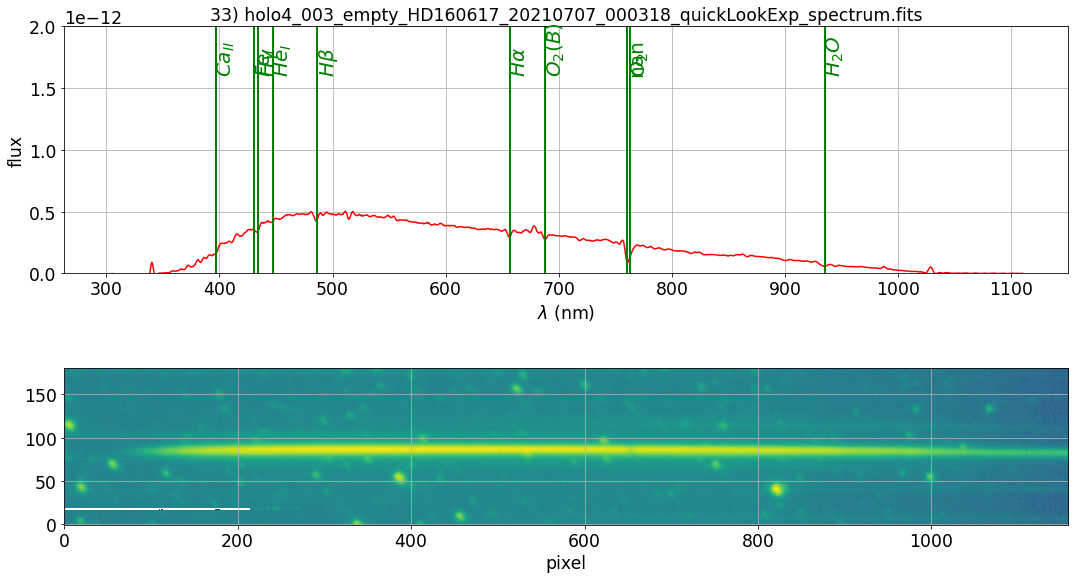

In [100]:
fig = plt.figure(figsize=(18,10))
ax=fig.add_subplot(2,1,1)
ax.plot(s.lambdas,s.data,"r-")
thetitle=str(IDXSEL)+") "+ filename_SEL
ax.set_title(thetitle)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux")
ax.grid()
ax.set_ylim(0,2e-12)
lines_collection.plot_atomic_lines(ax, color_atomic='g', color_atmospheric='b', fontsize=20, force=True)
ax=fig.add_subplot(2,1,2)
ax.imshow(spectrogram_image,origin="lower",norm=LogNorm())
ax.grid()
ax.set_xlabel("pixel")
plt.show()

## Tables

In [101]:
df_table=pd.read_csv(fullfilename_table_SEL,index_col=0)

In [102]:
df_table.head()

Dx        Dy  Dy_disp_axis    flux_sum  flux_integral  \
lambdas                                                                     
302.371567  425.464418 -5.211210     -1.412778   58.761400            1.0   
303.080377  426.464418 -5.202739     -1.416099   90.175958            1.0   
303.789176  427.464418 -5.194286     -1.419419  103.273297            1.0   
304.497964  428.464418 -5.185851     -1.422740  134.937636            1.0   
305.206741  429.464418 -5.177434     -1.426060  179.126000            1.0   

             flux_err      fwhm  Dy_fwhm_sup  Dy_fwhm_inf  amplitude  x_c  \
lambdas                                                                     
302.371567  18.741892  6.630305    -1.378545    -9.043874        1.0  0.0   
303.080377  18.843477  6.627023    -1.372978    -9.032499        1.0  1.0   
303.789176  18.924666  6.624511    -1.367412    -9.021160        1.0  2.0   
304.497964  19.065575  6.620397    -1.361845    -9.009857        1.0  3.0   
305.206741  19.285704  6.616703    -1.356279    -8.998589        1.0  4.0   

                  y_c     gamma     alpha  saturation  
lambdas                                                
302.371567  85.081380  5.894390  2.521326      8500.0  
303.080377  85.089851  5.889935  2.520591      8500.0  
303.789176  85.098304  5.885487  2.519858      8500.0  
304.497964  85.106739  5.881045  2.519125      8500.0  
305.206741  85.115156  5.876610  2.518394      8500.0

In [103]:
df_table.tail()

Dx        Dy  Dy_disp_axis    flux_sum  flux_integral  \
lambdas                                                                       
1106.120636  1578.464418 -7.409602     -5.241378   96.222844            1.0   
1106.800708  1579.464418 -7.421904     -5.244699  102.954105            1.0   
1107.480743  1580.464418 -7.434224     -5.248019  110.056578            1.0   
1108.160739  1581.464418 -7.446562     -5.251340  102.516796            1.0   
1108.840697  1582.464418 -7.458919     -5.254660  103.910478            1.0   

             flux_err      fwhm  Dy_fwhm_sup  Dy_fwhm_inf  amplitude     x_c  \
lambdas                                                                        
1106.120636  6.897696  6.050387    -3.665483   -11.153720        1.0  1153.0   
1106.800708  6.935110  6.053500    -3.676323   -11.167485        1.0  1154.0   
1107.480743  6.962892  6.056613    -3.687163   -11.181285        1.0  1155.0   
1108.160739  6.925093  6.059729    -3.696196   -11.196929        1.0  1156.0   
1108.840697  6.947604  6.062846    -3.705681   -11.212156        1.0  1157.0   

                   y_c     gamma     alpha  saturation  
lambdas                                                 
1106.120636  82.882988  5.236365  2.406600      8500.0  
1106.800708  82.870686  5.239686  2.407137      8500.0  
1107.480743  82.858366  5.243013  2.407675      8500.0  
1108.160739  82.846027  5.246347  2.408214      8500.0  
1108.840697  82.833671  5.249687  2.408754      8500.0

In [104]:
# df_table.index.get_level_values

In [105]:
# df_table.index.get_level_values

In [106]:
df_table['wl'] = df_table.index

In [107]:
#df_table.reset_index()

In [108]:
df_table.head()

Dx        Dy  Dy_disp_axis    flux_sum  flux_integral  \
lambdas                                                                     
302.371567  425.464418 -5.211210     -1.412778   58.761400            1.0   
303.080377  426.464418 -5.202739     -1.416099   90.175958            1.0   
303.789176  427.464418 -5.194286     -1.419419  103.273297            1.0   
304.497964  428.464418 -5.185851     -1.422740  134.937636            1.0   
305.206741  429.464418 -5.177434     -1.426060  179.126000            1.0   

             flux_err      fwhm  Dy_fwhm_sup  Dy_fwhm_inf  amplitude  x_c  \
lambdas                                                                     
302.371567  18.741892  6.630305    -1.378545    -9.043874        1.0  0.0   
303.080377  18.843477  6.627023    -1.372978    -9.032499        1.0  1.0   
303.789176  18.924666  6.624511    -1.367412    -9.021160        1.0  2.0   
304.497964  19.065575  6.620397    -1.361845    -9.009857        1.0  3.0   
305.206741  19.285704  6.616703    -1.356279    -8.998589        1.0  4.0   

                  y_c     gamma     alpha  saturation          wl  
lambdas                                                            
302.371567  85.081380  5.894390  2.521326      8500.0  302.371567  
303.080377  85.089851  5.889935  2.520591      8500.0  303.080377  
303.789176  85.098304  5.885487  2.519858      8500.0  303.789176  
304.497964  85.106739  5.881045  2.519125      8500.0  304.497964  
305.206741  85.115156  5.876610  2.518394      8500.0  305.206741

In [109]:
df_table.columns

Index(['Dx', 'Dy', 'Dy_disp_axis', 'flux_sum', 'flux_integral', 'flux_err',
       'fwhm', 'Dy_fwhm_sup', 'Dy_fwhm_inf', 'amplitude', 'x_c', 'y_c',
       'gamma', 'alpha', 'saturation', 'wl'],
      dtype='object')

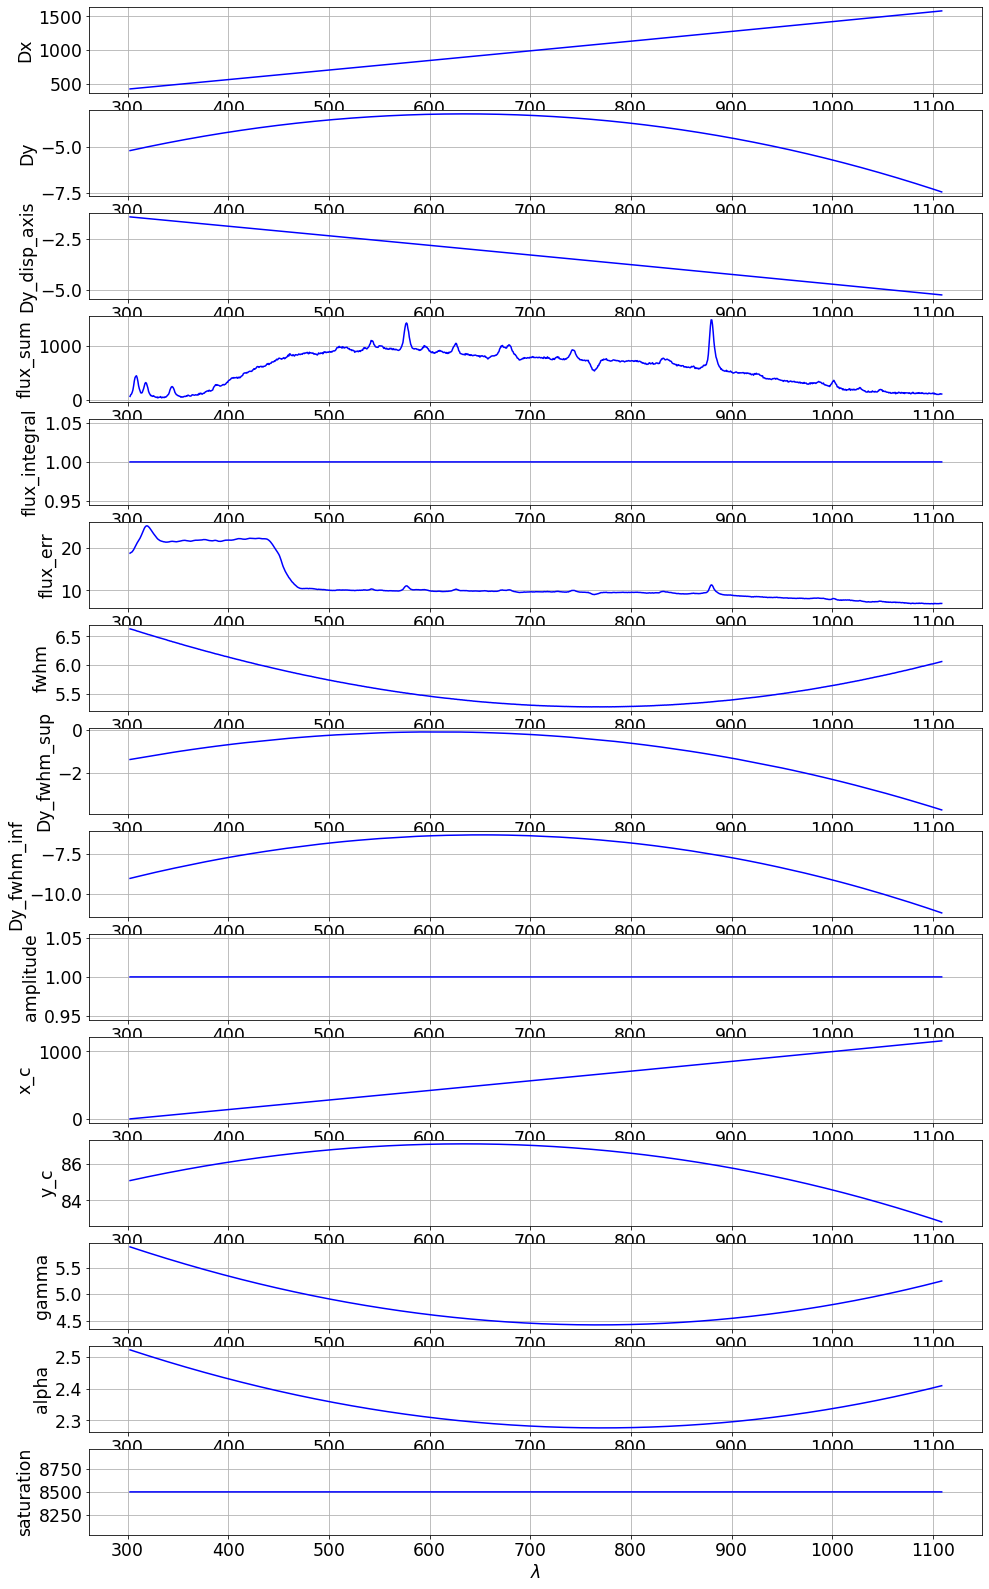

In [110]:
fig=plt.figure(figsize=(16,30))

idx=0
column_names=df_table.columns
NN=len(column_names)

# Dx
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel(column_names[idx-1])
ax.grid()
# Dy
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_disp_axis
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# flux_sum
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# flux_integral
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

#flux_err
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# fwhm

idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_fwhm_sup
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_fwhm_inf
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# amplitude 
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()


# x_c
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# y_c
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# gamma
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()


# alpha 
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# saturation
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()




# Atmospheric conditions

In [111]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [112]:
df_infos.set_index('idx',inplace=True)

In [113]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [114]:
all_reftime=np.array(all_reftime)

In [115]:
df_infos["reftime"]=all_reftime

In [116]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [117]:
df_infos

date_obs   airmass  temperature  pressure  humidity  \
idx                                                                       
0    2021-07-08T03:13:52.977  1.015856         12.1    742.55       5.0   
1    2021-07-08T03:18:17.588  1.015521         12.0    742.50       5.0   
2    2021-07-08T03:22:02.923  1.015531         12.2    742.60       4.0   
3    2021-07-08T03:26:56.497  1.015686         12.2    742.55       5.0   
4    2021-07-08T03:31:17.268  1.016083         12.1    742.50       5.0   
5    2021-07-08T03:40:26.734  1.017729         12.2    742.50       5.0   
6    2021-07-08T03:41:04.932  1.017834         12.2    742.50       5.0   
7    2021-07-08T03:41:43.265  1.017944         12.2    742.50       5.0   
8    2021-07-08T03:42:21.477  1.018061         12.2    742.50       5.0   
9    2021-07-08T03:42:59.670  1.018182         12.2    742.50       5.0   
10   2021-07-08T03:43:37.877  1.018466         12.1    742.50       5.0   
11   2021-07-08T03:44:54.833  1.018897         12.2    742.55       5.0   
12   2021-07-08T03:45:33.074  1.019041         12.1    742.50       5.0   
13   2021-07-08T03:46:11.170  1.019189         12.1    742.50       5.0   
14   2021-07-08T03:47:27.680  1.019662         12.1    742.50       5.0   
15   2021-07-08T03:48:44.787  1.020160         12.1    742.50       5.0   
16   2021-07-08T03:49:22.988  1.020338         12.0    742.50       5.0   
17   2021-07-08T03:50:01.157  1.020520         12.0    742.50       5.0   
18   2021-07-08T03:51:17.608  1.021060         12.1    742.55       5.0   
19   2021-07-08T03:52:35.003  1.021627         12.1    742.50       5.0   
20   2021-07-08T03:53:13.339  1.021840         12.1    742.50       5.0   
21   2021-07-08T03:53:51.643  1.022058         12.2    742.55       5.0   
22   2021-07-08T03:54:30.000  1.022283         12.2    742.50       5.0   
23   2021-07-08T03:55:08.239  1.022534         12.2    742.50       5.0   
24   2021-07-08T03:57:13.106  1.023421         12.2    742.50       5.0   
25   2021-07-08T04:01:18.322  1.025563         12.4    742.50       5.0   
26   2021-07-08T04:03:40.407  1.026817         12.4    742.50       5.0   
27   2021-07-08T04:07:02.095  1.028724         12.3    742.50       5.0   
28   2021-07-08T04:07:34.532  1.029039         12.3    742.50       6.0   
29   2021-07-08T04:08:06.978  1.029386         12.3    742.50       6.0   
30   2021-07-08T04:10:49.848  1.031077         12.1    742.55       6.0   
31   2021-07-08T04:11:22.266  1.031420         12.1    742.55       6.0   
32   2021-07-08T04:11:54.729  1.031795         12.1    742.55       6.0   
33   2021-07-08T04:49:50.137  1.066803         12.4    742.30       6.0   
34   2021-07-08T04:50:22.375  1.067444         12.4    742.30       6.0   
35   2021-07-08T04:50:54.636  1.068087         12.4    742.30       6.0   
36   2021-07-08T04:51:26.881  1.068735         12.5    742.30       6.0   
37   2021-07-08T04:51:59.136  1.069388         12.5    742.30       6.0   
38   2021-07-08T04:52:31.378  1.070115         12.6    742.30       6.0   
39   2021-07-08T04:53:04.132  1.070860         12.6    742.30       6.0   
40   2021-07-08T04:53:36.377  1.071527         12.6    742.25       6.0   
41   2021-07-08T04:54:08.639  1.072198         12.6    742.25       6.0   
42   2021-07-08T04:55:13.186  1.073559         12.6    742.25       6.0   
43   2021-07-08T04:55:45.426  1.074244         12.6    742.30       6.0   
44   2021-07-08T04:56:17.680  1.075006         12.6    742.30       6.0   
45   2021-07-08T04:56:50.399  1.075787         12.6    742.30       6.0   
46   2021-07-08T04:57:22.671  1.076486         12.6    742.35       6.0   
47   2021-07-08T04:58:27.184  1.077900         12.6    742.30       6.0   
48   2021-07-08T04:58:59.509  1.078618         12.6    742.30       6.0   
49   2021-07-08T04:59:31.782  1.079336         12.6    742.25       6.0   
50   2021-07-08T05:00:04.019  1.080135         12.6    742.25       6.0   
51   2021-07-08T05:00:36.734  1.080950       

# STOP HERE

In [118]:
assert False

AssertionError: 

# Selection of spectra and equivalent width calculation

In [ ]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

In [ ]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [ ]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
filename_lines_SEL=filename_SEL.replace("_spectrum.fits","_lines.csv")
filename_table_SEL=filename_SEL.replace("_spectrum.fits","_table.csv")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL = fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL = fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [ ]:
fullfilename_table_SEL

In [ ]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [ ]:
thetitle

In [ ]:
fullfilename_SEL

## Load spectrum and Spectrogram

In [ ]:
s=Spectrum(fullfilename_SEL, config=config)
s.load_spectrogram(fullfilename_spectrogram_SEL) 

In [ ]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [ ]:
df_lines

In [ ]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [ ]:
s.lines = lines

In [ ]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [ ]:
# global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

In [ ]:
fig = plt.figure(figsize=(18,10))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [ ]:
# lines.print_detected_lines()

In [ ]:
alert False

## with specutils

### Convert in specutils units

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [ ]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [ ]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [ ]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [ ]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,7):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [ ]:
print(lines.print_detected_lines())

In [ ]:
type(lines.print_detected_lines())

In [ ]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

In [ ]:
df_infos

# Loop on spectrum, compute O2 line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):

    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [ ]:
df_infos

In [ ]:
df_infos.to_csv("eqw.csv")

In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

In [ ]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")